# <span style="color:teal"> __Shannon Index or Shannaon's diversity index__

The **Shannon index** (also called **Shannon entropy** or **Shannon diversity index**) is a commonly used metric in ecology and microbiome studies to quantify **alpha diversity**—the diversity **within a single sample**. It accounts for both **richness** (the number of different species or taxa) and **evenness** (how evenly individuals are distributed among those taxa).

Mathematically, it is defined as:

$$
H' = -\sum_{i=1}^{S} p_i \cdot \ln(p_i)
$$

Where:

* $S$ = total number of species (or taxa)
* $p_i$ = proportion of the $i$-th species in the sample

A higher Shannon index indicates greater diversity, meaning the community is composed of many species with relatively even abundances. A lower value suggests fewer species or dominance by a few.
_________


In [33]:
#Loading all the packages
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import seaborn as sns
from tqdm import tqdm
import random
import json
import textwrap

In [34]:
# SHANNON DIVERSITY INDEX FORMULA
def shannon_index(abundances):
    proportions = abundances / abundances.sum()
    proportions = proportions[proportions > 0]
    return -np.sum(proportions * np.log(proportions))

In [35]:
# DATASET LOADING AT GENUS AND SPECIES LEVEL
df_genus= pd.read_csv('/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmrepo_curated_data/disease_genus_abundance.txt', sep = '\t')
df_species = pd.read_csv('/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmrepo_curated_data/disease_species_abundance.txt', sep = '\t')

In [36]:
# IMPORT DISEASE DICTIONARY

# Load disease code to name mapping
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/disease_dict.json", "r") as f:
    disease_dict = json.load(f)
    
# Load the phenotype mapping JSON
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/disease_classification.json", "r") as f:
    disease_category_by_id = json.load(f)



___
__GENUS LEVEL__
____

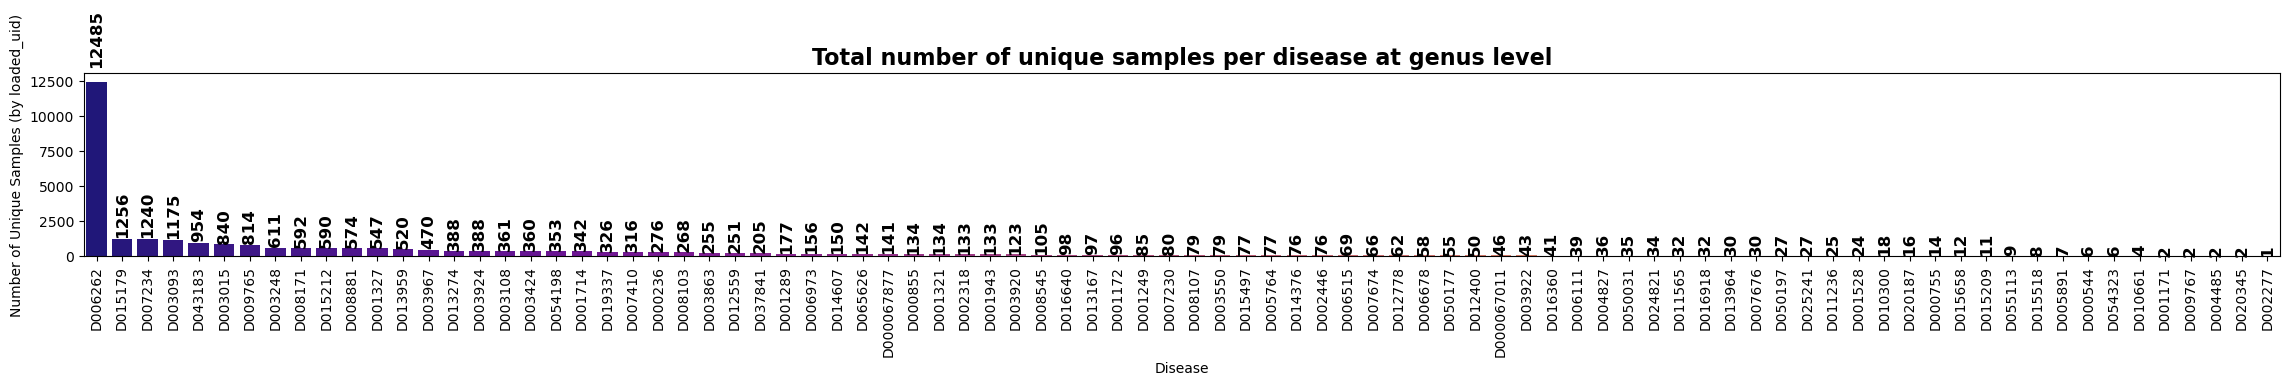

In [37]:
# Group and sort
unique_sample_counts = df_genus.groupby('disease')['loaded_uid'].nunique().reset_index()
unique_sample_counts.columns = ['disease', 'unique_sample_count']
unique_sample_counts = unique_sample_counts.sort_values('unique_sample_count', ascending=False)

# Plot
plt.figure(figsize=(23, 4))
ax = sns.barplot(
    data=unique_sample_counts,
    x='disease',
    y='unique_sample_count',
    hue='disease',
    dodge=False,
    palette='plasma',
    legend=False
)

# Add vertical count labels with proper spacing above the bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + height * 0.08,  # Increased vertical offset (8% of height)
        f'{int(height)}',
        ha='center',
        va='bottom',
        rotation=90,
        fontsize=12,
        fontweight='bold',
        color='black'
    )

# Final formatting
plt.xticks(rotation=90)
plt.xlabel('Disease')
plt.ylabel('Number of Unique Samples (by loaded_uid)')
plt.title('Total number of unique samples per disease at genus level', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [38]:
# GENUS FILTERING DISEASE LESS THAN 30 SAMPLES

# Step 0: Count total unique samples before filtering
total_unique_samples_before = df_genus['loaded_uid'].nunique()

# Step 1: Count number of unique samples per disease
sample_counts = df_genus.groupby('disease')['loaded_uid'].nunique()

# Step 2: Identify valid and removed diseases
valid_diseases = sample_counts[sample_counts >= 30].index
removed_diseases = sample_counts[sample_counts < 30].index

# Step 3: Filter the long-format table
df_genus_filtered = df_genus[df_genus['disease'].isin(valid_diseases)].copy()

# Step 4: Count total unique samples after filtering
total_unique_samples_after = df_genus_filtered['loaded_uid'].nunique()

# Step 5: Print summary
print("Descriptive Summary for Genus Level data")
print(f"✅ Total unique samples before filtering: {total_unique_samples_before}")
print(f"✅ Total diseases before filtering: {sample_counts.shape[0]}")
print(f"❌ Diseases removed (with <30 samples): {removed_diseases.shape[0]}")
print(f"✅ Remaining diseases: {len(valid_diseases)}")
print(f"✅ Remaining unique samples after filtering: {total_unique_samples_after}")

Descriptive Summary for Genus Level data
✅ Total unique samples before filtering: 26834
✅ Total diseases before filtering: 86
❌ Diseases removed (with <30 samples): 20
✅ Remaining diseases: 66
✅ Remaining unique samples after filtering: 26618


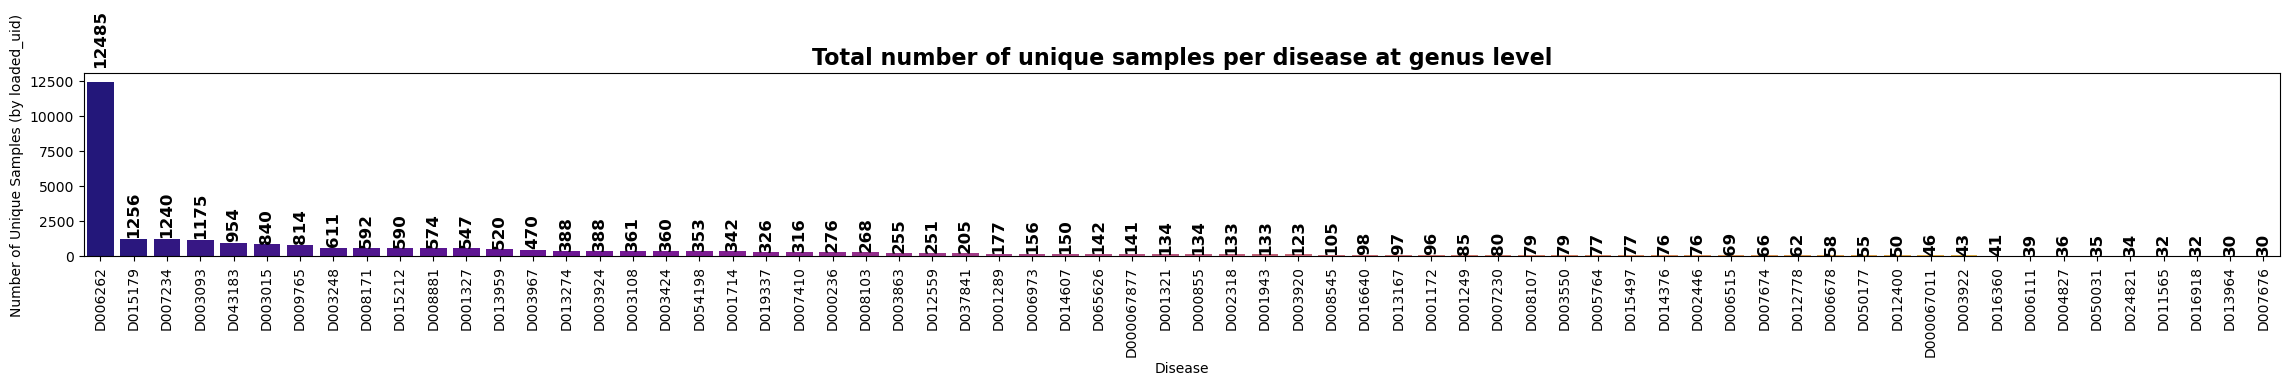

In [39]:
# Group and sort
unique_sample_counts = df_genus_filtered.groupby('disease')['loaded_uid'].nunique().reset_index()
unique_sample_counts.columns = ['disease', 'unique_sample_count']
unique_sample_counts = unique_sample_counts.sort_values('unique_sample_count', ascending=False)

# Plot
plt.figure(figsize=(23, 4))
ax = sns.barplot(
    data=unique_sample_counts,
    x='disease',
    y='unique_sample_count',
    hue='disease',
    dodge=False,
    palette='plasma',
    legend=False
)

# Add vertical count labels with proper spacing above the bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + height * 0.08,  # Increased vertical offset (8% of height)
        f'{int(height)}',
        ha='center',
        va='bottom',
        rotation=90,
        fontsize=12,
        fontweight='bold',
        color='black'
    )

# Final formatting
plt.xticks(rotation=90)
plt.xlabel('Disease')
plt.ylabel('Number of Unique Samples (by loaded_uid)')
plt.title('Total number of unique samples per disease at genus level', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [40]:
# SHANNON INDEX CALCULATION
# Pivot the filtered DataFrame to create a wide-format table for genus
df_genus_pivoted = df_genus_filtered.pivot_table(
    index=['loaded_uid', 'disease'],
    columns='ncbi_taxon_id',
    values='relative_abundance',
    aggfunc='sum',
    fill_value=0
)

df_genus_pivoted['shannon'] = df_genus_pivoted.apply(shannon_index, axis=1)
df_genus_shannon = df_genus_pivoted['shannon'].reset_index()
df_genus_shannon

,loaded_uid,disease,shannon
0,1,D006262,1.639208
1,2,D003924,2.604857
2,3,D006262,0.615648
3,6,D006262,2.270188
4,7,D006262,2.328094
...,...,...,...
29958,52855,D003093,1.948645
29959,52856,D003093,1.445619
29960,52857,D003093,1.980350
29961,52858,D003093,1.702156


## <span style="color:teal"> __KRUSKAL WALLIS + DUNN POST HOC + FDR BENJAMINI HOCHBERG TEST__
<span style="color:teal"> We used the __Kruskal–Wallis H test__, a non-parametric alternative to ANOVA, to assess whether Shannon diversity differed significantly across disease groups compared to healthy controls. This test does not assume normality and is suitable for comparing distributions across multiple groups with unequal sample sizes. When the Kruskal–Wallis test indicated a significant overall difference, we performed post hoc pairwise comparisons using Dunn’s test to identify which specific diseases differed from the healthy group. To account for multiple testing across the large number of disease comparisons, we applied false discovery rate (FDR) correction to the p-values. This approach provides a statistically robust and interpretable framework for identifying diseases associated with significant shifts in microbial diversity.
___

In [41]:

# --------------------------------------------
# KRUSKAL–WALLIS AND DUNN POST HOC TESTS (GENUS LEVEL)
# --------------------------------------------

# Step 0: Ensure 'disease' column is string
df_genus_shannon['disease'] = df_genus_shannon['disease'].astype(str)

# Step 1: Define healthy group code
healthy_label = 'D006262'  # Replace if your healthy code is different

# Step 2: Filter only groups with ≥30 samples
eligible_groups = [
    group for _, group in df_genus_shannon.groupby('disease') if len(group) >= 30
]

# Step 3: Downsample every eligible group to exactly 30 samples
df_downsampled_genus = pd.concat([
    group.sample(n=30, random_state=42)
    for group in eligible_groups
])

# Tag level
df_downsampled_genus['level'] = 'genus'

# Step 4: Ensure healthy group is present after downsampling
if healthy_label not in df_downsampled_genus['disease'].unique():
    raise ValueError(f"Healthy label '{healthy_label}' not found in downsampled data.")

# Step 5: Perform Kruskal–Wallis test
groups_all = [
    group['shannon'].values
    for _, group in df_downsampled_genus.groupby('disease')
]
kw_stat, kw_pval = kruskal(*groups_all)

print(f"\nKruskal–Wallis H-test (genus-level, downsampled)")
print(f"H-statistic = {kw_stat:.4f}")
print(f"P-value     = {kw_pval:.4e}")

# Step 6: Perform Dunn’s test if Kruskal–Wallis is significant
if kw_pval < 0.05:
    print("\nPerforming Dunn’s test with FDR correction (vs. Healthy)...")

    dunn_matrix_genus = sp.posthoc_dunn(
        df_downsampled_genus,
        val_col='shannon',
        group_col='disease',
        p_adjust='fdr_bh'
    )

    # Check healthy group is in the matrix
    if healthy_label not in dunn_matrix_genus.index or healthy_label not in dunn_matrix_genus.columns:
        raise KeyError(f"Healthy group '{healthy_label}' not found in Dunn matrix.")

    # Extract only comparisons vs Healthy (excluding diagonal)
    dunn_vs_healthy_genus = dunn_matrix_genus[healthy_label].drop(index=healthy_label, errors='ignore')
    dunn_vs_healthy_genus = dunn_vs_healthy_genus.sort_values()

    # Format output table
    df_dunn_vs_healthy_genus = pd.DataFrame({
        'Disease Code': dunn_vs_healthy_genus.index,
        'FDR-adjusted p-value': dunn_vs_healthy_genus.values,
    }).reset_index(drop=True)

    df_dunn_vs_healthy_genus['Significant (FDR < 0.05)'] = (
        df_dunn_vs_healthy_genus['FDR-adjusted p-value'] < 0.05
    )

    # Tag level
    df_dunn_vs_healthy_genus['level'] = 'genus'

    # Show final table
    print("\nDunn’s Post Hoc Test: Healthy vs Each Disease")
    display(df_dunn_vs_healthy_genus)

else:
    print("\nKruskal–Wallis not significant — skipping Dunn’s test.")
    df_dunn_vs_healthy_genus = None



Kruskal–Wallis H-test (genus-level, downsampled)
H-statistic = 626.4688
P-value     = 9.2019e-93

Performing Dunn’s test with FDR correction (vs. Healthy)...

Dunn’s Post Hoc Test: Healthy vs Each Disease


,Disease Code,FDR-adjusted p-value,Significant (FDR < 0.05),level
0,D007234,2.460623e-08,True,genus
1,D001249,1.471729e-06,True,genus
2,D013274,2.943279e-06,True,genus
3,D013964,1.838407e-05,True,genus
4,D014376,1.035725e-04,True,genus
...,...,...,...,...
60,D008171,8.496490e-01,False,genus
61,D003248,9.015729e-01,False,genus
62,D003924,9.024621e-01,False,genus
63,D037841,9.486239e-01,False,genus


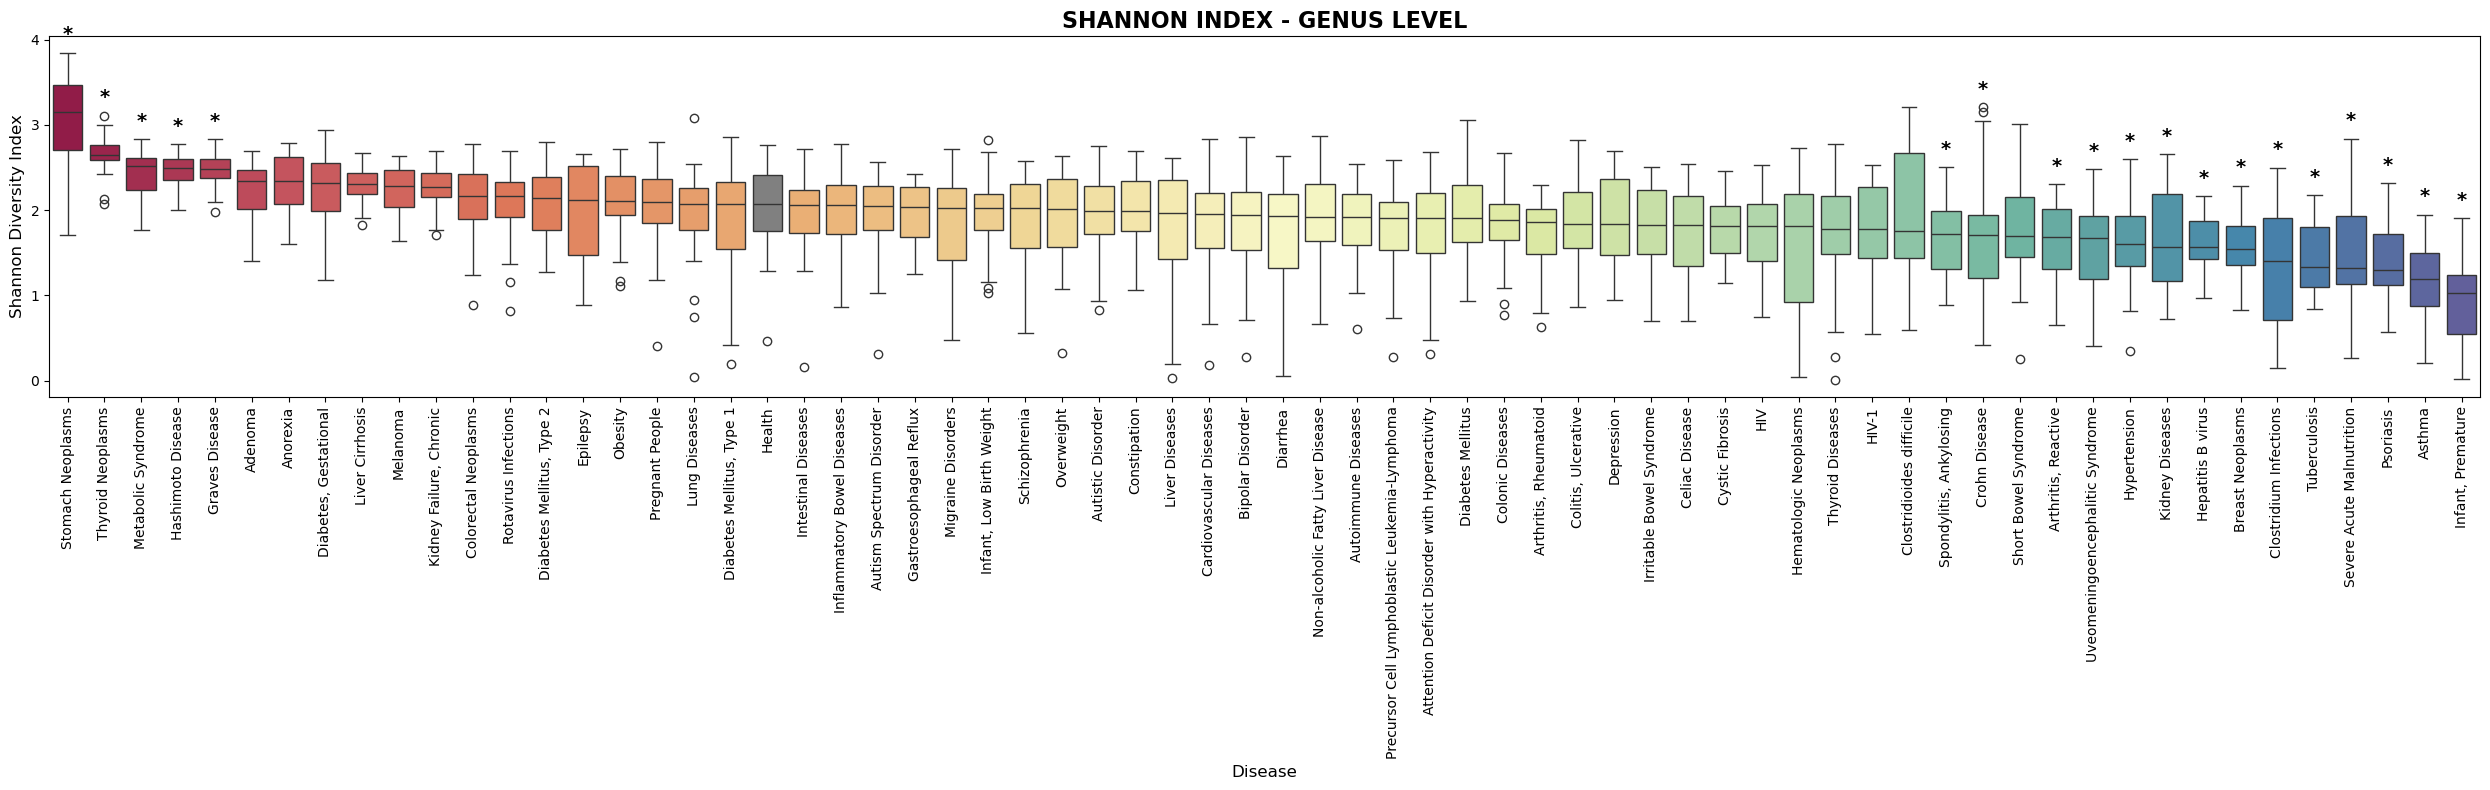

In [42]:
# PLOT SHANNON INDEX AT GENUS LEVEL
# --------------------------
# Define healthy label
# --------------------------
healthy_label = 'D006262'
healthy_name = disease_dict.get(healthy_label, 'Healthy')

# --------------------------
# Use downsampled dataset
# --------------------------
df_plot_genus = df_downsampled_genus.copy()

# --------------------------
# Map disease codes to readable names
# --------------------------
df_plot_genus['disease_name'] = df_plot_genus['disease'].map(disease_dict)

# --------------------------
# Extract significant disease codes and convert to names
# --------------------------
if df_dunn_vs_healthy_genus is not None:
    significant_diseases = df_dunn_vs_healthy_genus.query("`Significant (FDR < 0.05)`")['Disease Code'].tolist()
    significant_names = [disease_dict.get(code, code) for code in significant_diseases]
else:
    significant_names = []

df_plot_genus['significant'] = df_plot_genus['disease_name'].isin(significant_names)

# --------------------------
# Sort diseases by median Shannon
# --------------------------
ordered_names = (
    df_plot_genus.groupby("disease_name")["shannon"]
    .median()
    .sort_values(ascending=False)
    .index
)

# --------------------------
# Create color palette
# --------------------------
palette = sns.color_palette("Spectral", n_colors=len(ordered_names) - 1)
color_dict = {}
palette_idx = 0

for name in ordered_names:
    if name == healthy_name:
        color_dict[name] = 'grey'
    else:
        color_dict[name] = palette[palette_idx]
        palette_idx += 1

# --------------------------
# Create boxplot
# --------------------------
plt.figure(figsize=(25, 8))
ax = sns.boxplot(
    data=df_plot_genus,
    x="disease_name",
    y="shannon",
    order=ordered_names,
    hue="disease_name",
    palette=color_dict,
    dodge=False,
    legend=False
)

# --------------------------
# Annotate significant diseases with asterisk
# --------------------------
for i, name in enumerate(ordered_names):
    if name in significant_names:
        max_val = df_plot_genus[df_plot_genus['disease_name'] == name]['shannon'].max()
        ax.text(
            i,
            max_val + 0.1,
            "*",
            ha='center',
            va='bottom',
            fontsize=14,
            fontweight='bold',
            color='black'
        )

# --------------------------
# Format plot
# --------------------------
plt.xticks(rotation=90)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.xlabel("Disease", fontsize=12)
plt.ylabel("Shannon Diversity Index", fontsize=12)
plt.title("SHANNON INDEX - GENUS LEVEL", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


___
___
___


___
__SPECIES LEVEL__
____

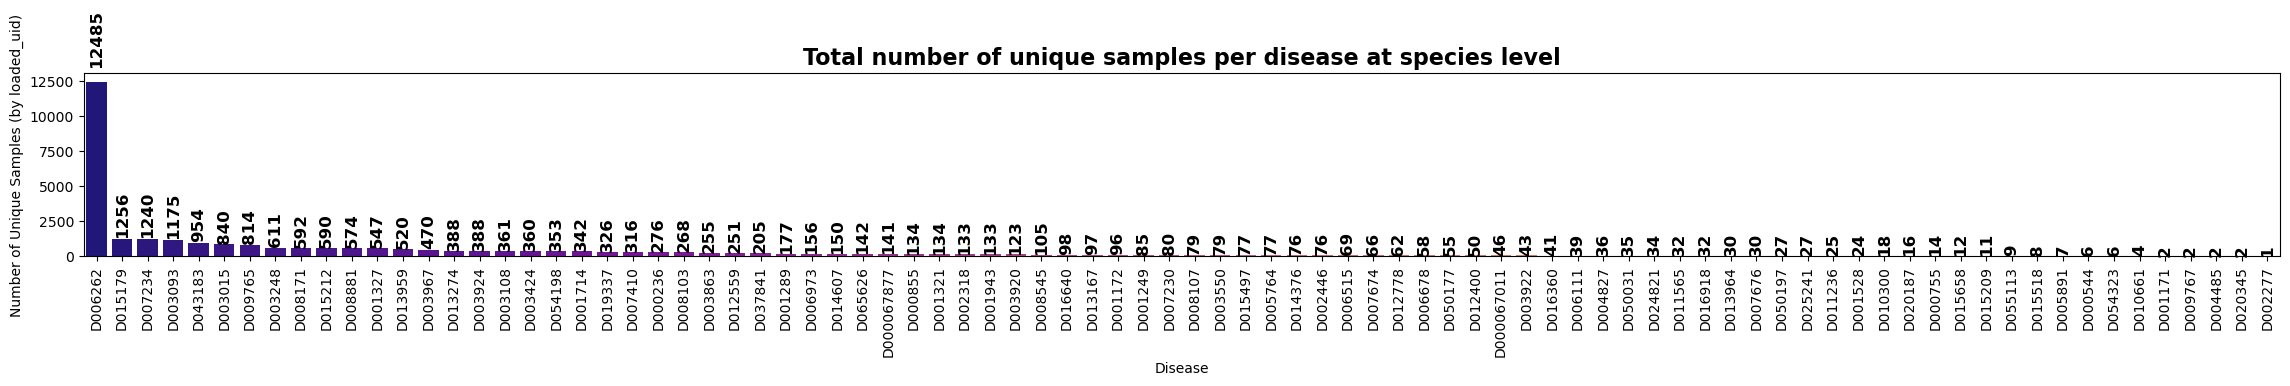

In [43]:
# Group and sort
unique_sample_counts = df_species.groupby('disease')['loaded_uid'].nunique().reset_index()
unique_sample_counts.columns = ['disease', 'unique_sample_count']
unique_sample_counts = unique_sample_counts.sort_values('unique_sample_count', ascending=False)

# Plot
plt.figure(figsize=(23, 4))
ax = sns.barplot(
    data=unique_sample_counts,
    x='disease',
    y='unique_sample_count',
    hue='disease',
    dodge=False,
    palette='plasma',
    legend=False
)

# Add vertical count labels with proper spacing above the bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + height * 0.08,  # Increased vertical offset (8% of height)
        f'{int(height)}',
        ha='center',
        va='bottom',
        rotation=90,
        fontsize=12,
        fontweight='bold',
        color='black'
    )

# Final formatting
plt.xticks(rotation=90)
plt.xlabel('Disease')
plt.ylabel('Number of Unique Samples (by loaded_uid)')
plt.title('Total number of unique samples per disease at species level', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [44]:
# SPECIES FILTERING DISEASE LESS THAN 30 SAMPLES

# Step 0: Count total unique samples before filtering
total_unique_samples_before = df_species['loaded_uid'].nunique()

# Step 1: Count number of unique samples per disease
sample_counts = df_species.groupby('disease')['loaded_uid'].nunique()

# Step 2: Identify valid and removed diseases
valid_diseases = sample_counts[sample_counts >= 30].index
removed_diseases = sample_counts[sample_counts < 30].index

# Step 3: Filter the long-format table
df_species_filtered = df_species[df_species['disease'].isin(valid_diseases)].copy()

# Step 4: Count total unique samples after filtering
total_unique_samples_after = df_species_filtered['loaded_uid'].nunique()

# Step 5: Print summary
print("Descriptive Summary for Species Level data")
print(f"✅ Total unique samples before filtering: {total_unique_samples_before}")
print(f"✅ Total diseases before filtering: {sample_counts.shape[0]}")
print(f"❌ Diseases removed (with <60 samples): {removed_diseases.shape[0]}")
print(f"✅ Remaining diseases: {len(valid_diseases)}")
print(f"✅ Remaining unique samples after filtering: {total_unique_samples_after}")

Descriptive Summary for Species Level data
✅ Total unique samples before filtering: 26834
✅ Total diseases before filtering: 86
❌ Diseases removed (with <60 samples): 20
✅ Remaining diseases: 66
✅ Remaining unique samples after filtering: 26618


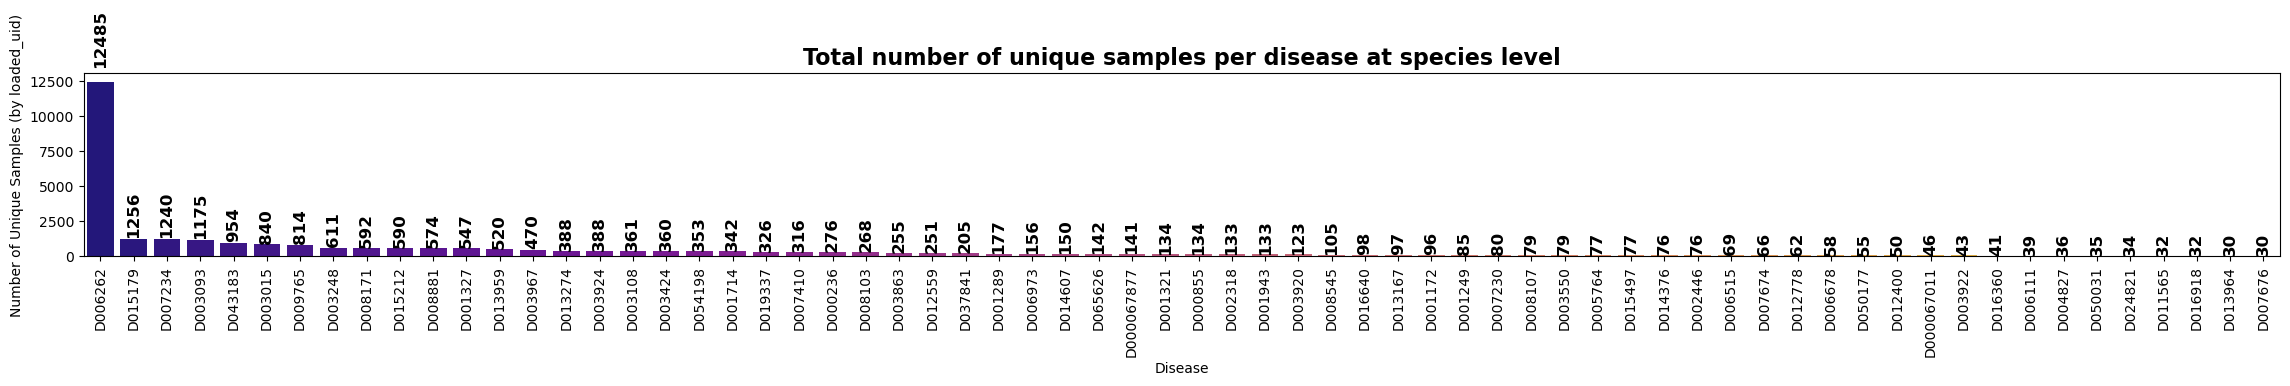

In [45]:
# Group and sort
unique_sample_counts = df_species_filtered.groupby('disease')['loaded_uid'].nunique().reset_index()
unique_sample_counts.columns = ['disease', 'unique_sample_count']
unique_sample_counts = unique_sample_counts.sort_values('unique_sample_count', ascending=False)

# Plot
plt.figure(figsize=(23, 4))
ax = sns.barplot(
    data=unique_sample_counts,
    x='disease',
    y='unique_sample_count',
    hue='disease',
    dodge=False,
    palette='plasma',
    legend=False
)

# Add vertical count labels with proper spacing above the bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + height * 0.08,  # Increased vertical offset (8% of height)
        f'{int(height)}',
        ha='center',
        va='bottom',
        rotation=90,
        fontsize=12,
        fontweight='bold',
        color='black'
    )

# Final formatting
plt.xticks(rotation=90)
plt.xlabel('Disease')
plt.ylabel('Number of Unique Samples (by loaded_uid)')
plt.title('Total number of unique samples per disease at species level', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [46]:
# SHANNON INDEX CALCULATION
# Pivot the filtered DataFrame to create a wide-format table for species
df_species_pivoted = df_species_filtered.pivot_table(
    index=['loaded_uid', 'disease'],
    columns='ncbi_taxon_id',
    values='relative_abundance',
    aggfunc='sum',
    fill_value=0
)

df_species_pivoted['shannon'] = df_species_pivoted.apply(shannon_index, axis=1)
df_species_shannon = df_species_pivoted['shannon'].reset_index()
df_species_shannon

,loaded_uid,disease,shannon
0,1,D006262,2.081467
1,2,D003924,3.221914
2,3,D006262,1.344692
3,6,D006262,2.644656
4,7,D006262,2.948928
...,...,...,...
29958,52855,D003093,1.948632
29959,52856,D003093,1.838057
29960,52857,D003093,2.130105
29961,52858,D003093,1.854410


## <span style="color:teal"> __KRUSKAL WALLIS + DUNN POST HOC + FDR BENJAMINI HOCHBERG TEST__
<span style="color:teal"> We used the __Kruskal–Wallis H test__, a non-parametric alternative to ANOVA, to assess whether Shannon diversity differed significantly across disease groups compared to healthy controls. This test does not assume normality and is suitable for comparing distributions across multiple groups with unequal sample sizes. When the Kruskal–Wallis test indicated a significant overall difference, we performed post hoc pairwise comparisons using Dunn’s test to identify which specific diseases differed from the healthy group. To account for multiple testing across the large number of disease comparisons, we applied false discovery rate (FDR) correction to the p-values. This approach provides a statistically robust and interpretable framework for identifying diseases associated with significant shifts in microbial diversity.
___

In [47]:

# --------------------------------------------
# KRUSKAL–WALLIS AND DUNN POST HOC TESTS (species LEVEL)
# --------------------------------------------

# Step 0: Ensure 'disease' column is string
df_species_shannon['disease'] = df_species_shannon['disease'].astype(str)

# Step 1: Define healthy group code
healthy_label = 'D006262'  # Replace if your healthy code is different

# Step 2: Filter only groups with ≥30 samples
eligible_groups = [
    group for _, group in df_species_shannon.groupby('disease') if len(group) >= 30
]

# Step 3: Downsample every eligible group to exactly 30 samples
df_downsampled_species = pd.concat([
    group.sample(n=30, random_state=42)
    for group in eligible_groups
])

# Tag level
df_downsampled_species['level'] = 'species'

# Step 4: Ensure healthy group is present after downsampling
if healthy_label not in df_downsampled_species['disease'].unique():
    raise ValueError(f"Healthy label '{healthy_label}' not found in downsampled data.")

# Step 5: Perform Kruskal–Wallis test
groups_all = [
    group['shannon'].values
    for _, group in df_downsampled_species.groupby('disease')
]
kw_stat, kw_pval = kruskal(*groups_all)

print(f"\nKruskal–Wallis H-test (species-level, downsampled)")
print(f"H-statistic = {kw_stat:.4f}")
print(f"P-value     = {kw_pval:.4e}")

# Step 6: Perform Dunn’s test if Kruskal–Wallis is significant
if kw_pval < 0.05:
    print("\nPerforming Dunn’s test with FDR correction (vs. Healthy)...")

    dunn_matrix_species = sp.posthoc_dunn(
        df_downsampled_species,
        val_col='shannon',
        group_col='disease',
        p_adjust='fdr_bh'
    )

    # Check healthy group is in the matrix
    if healthy_label not in dunn_matrix_species.index or healthy_label not in dunn_matrix_species.columns:
        raise KeyError(f"Healthy group '{healthy_label}' not found in Dunn matrix.")

    # Extract only comparisons vs Healthy (excluding diagonal)
    dunn_vs_healthy_species = dunn_matrix_species[healthy_label].drop(index=healthy_label, errors='ignore')
    dunn_vs_healthy_species = dunn_vs_healthy_species.sort_values()

    # Format output table
    df_dunn_vs_healthy_species = pd.DataFrame({
        'Disease Code': dunn_vs_healthy_species.index,
        'FDR-adjusted p-value': dunn_vs_healthy_species.values,
    }).reset_index(drop=True)

    df_dunn_vs_healthy_species['Significant (FDR < 0.05)'] = (
        df_dunn_vs_healthy_species['FDR-adjusted p-value'] < 0.05
    )

    # Tag level
    df_dunn_vs_healthy_species['level'] = 'species'

    # Show final table
    print("\nDunn’s Post Hoc Test: Healthy vs Each Disease")
    display(df_dunn_vs_healthy_species)

else:
    print("\nKruskal–Wallis not significant — skipping Dunn’s test.")
    df_dunn_vs_healthy_species = None



Kruskal–Wallis H-test (species-level, downsampled)
H-statistic = 554.9773
P-value     = 6.8649e-79

Performing Dunn’s test with FDR correction (vs. Healthy)...

Dunn’s Post Hoc Test: Healthy vs Each Disease


,Disease Code,FDR-adjusted p-value,Significant (FDR < 0.05),level
0,D007234,6.087080e-09,True,species
1,D013274,1.610282e-06,True,species
2,D013964,1.340792e-05,True,species
3,D001249,2.343164e-04,True,species
4,D003015,1.162524e-03,True,species
...,...,...,...,...
60,D004827,9.576966e-01,False,species
61,D003093,9.707848e-01,False,species
62,D016360,9.758309e-01,False,species
63,D008171,9.838998e-01,False,species


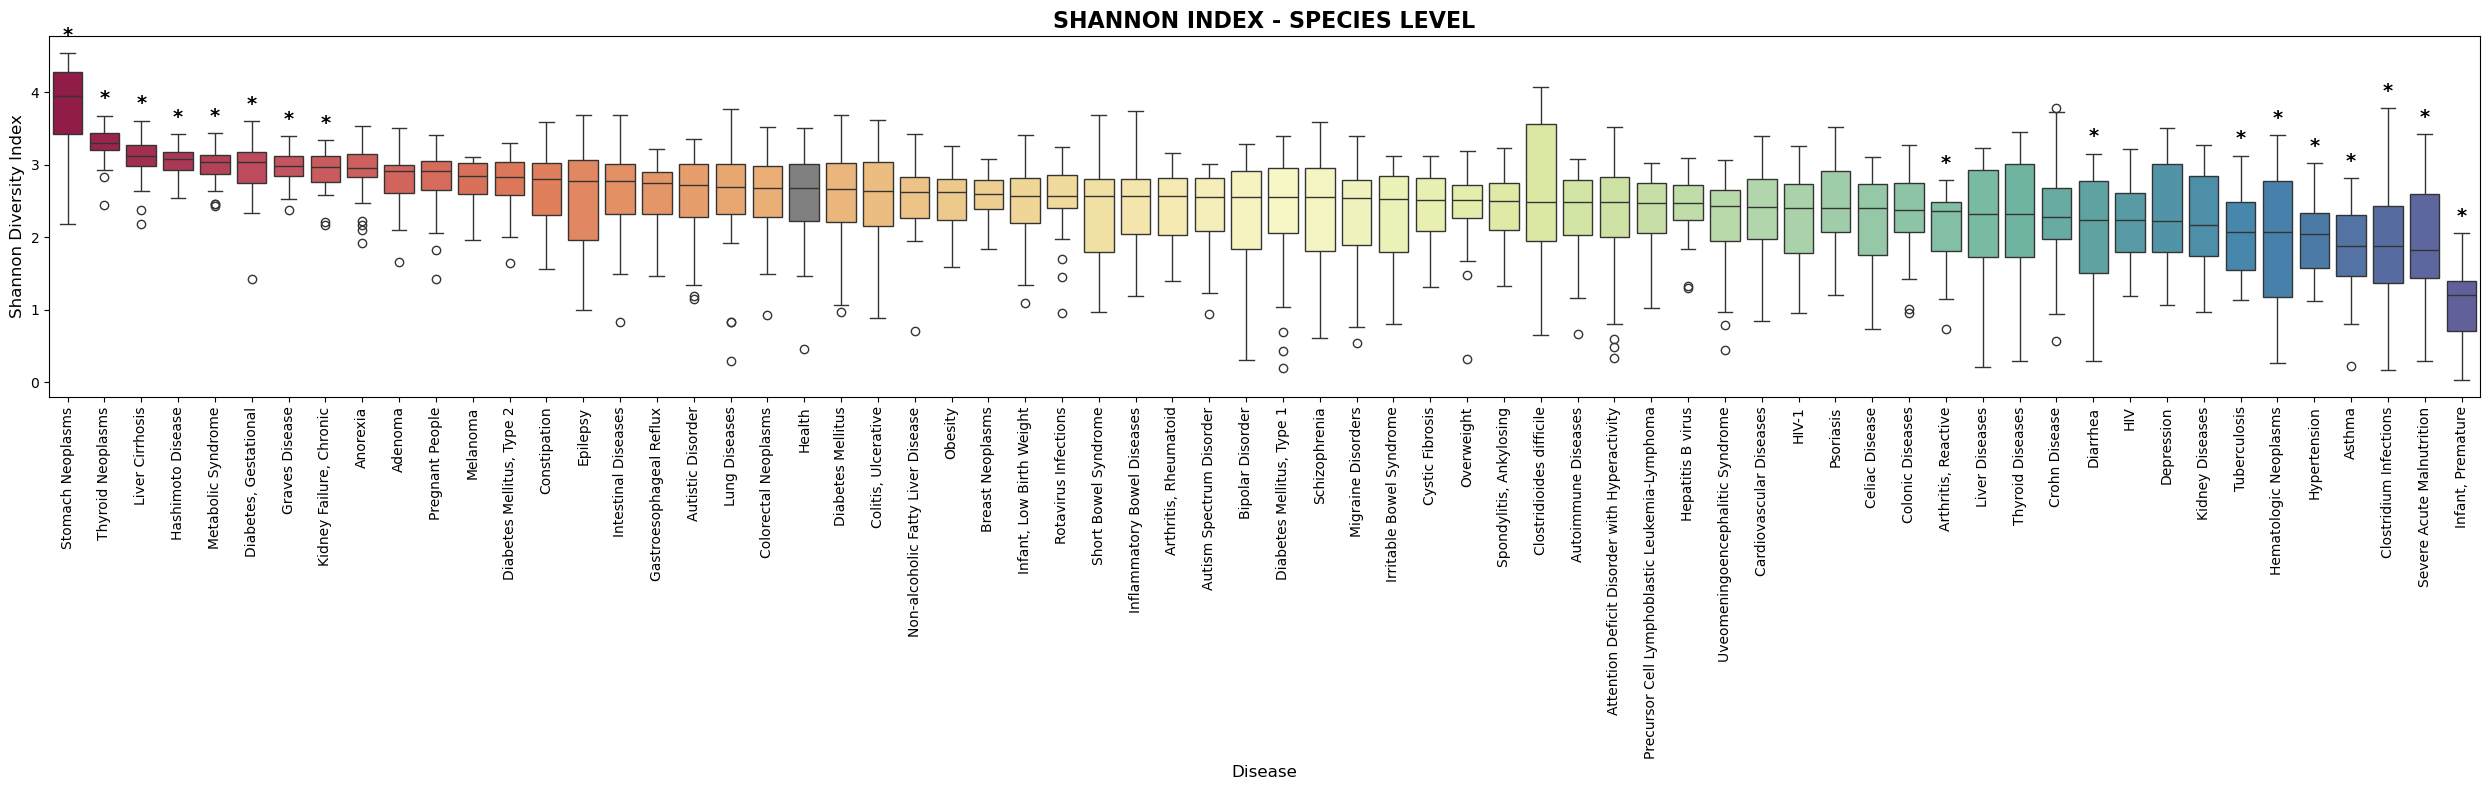

In [48]:
# PLOT SHANNON INDEX AT species LEVEL
# --------------------------
# Define healthy label
# --------------------------
healthy_label = 'D006262'
healthy_name = disease_dict.get(healthy_label, 'Healthy')

# --------------------------
# Use downsampled dataset
# --------------------------
df_plot_species = df_downsampled_species.copy()

# --------------------------
# Map disease codes to readable names
# --------------------------
df_plot_species['disease_name'] = df_plot_species['disease'].map(disease_dict)

# --------------------------
# Extract significant disease codes and convert to names
# --------------------------
if df_dunn_vs_healthy_species is not None:
    significant_diseases = df_dunn_vs_healthy_species.query("`Significant (FDR < 0.05)`")['Disease Code'].tolist()
    significant_names = [disease_dict.get(code, code) for code in significant_diseases]
else:
    significant_names = []

df_plot_species['significant'] = df_plot_species['disease_name'].isin(significant_names)

# --------------------------
# Sort diseases by median Shannon
# --------------------------
ordered_names = (
    df_plot_species.groupby("disease_name")["shannon"]
    .median()
    .sort_values(ascending=False)
    .index
)

# --------------------------
# Create color palette
# --------------------------
palette = sns.color_palette("Spectral", n_colors=len(ordered_names) - 1)
color_dict = {}
palette_idx = 0

for name in ordered_names:
    if name == healthy_name:
        color_dict[name] = 'grey'
    else:
        color_dict[name] = palette[palette_idx]
        palette_idx += 1

# --------------------------
# Create boxplot
# --------------------------
plt.figure(figsize=(25, 8))
ax = sns.boxplot(
    data=df_plot_species,
    x="disease_name",
    y="shannon",
    order=ordered_names,
    hue="disease_name",
    palette=color_dict,
    dodge=False,
    legend=False
)

# --------------------------
# Annotate significant diseases with asterisk
# --------------------------
for i, name in enumerate(ordered_names):
    if name in significant_names:
        max_val = df_plot_species[df_plot_species['disease_name'] == name]['shannon'].max()
        ax.text(
            i,
            max_val + 0.1,
            "*",
            ha='center',
            va='bottom',
            fontsize=14,
            fontweight='bold',
            color='black'
        )

# --------------------------
# Format plot
# --------------------------
plt.xticks(rotation=90)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.xlabel("Disease", fontsize=12)
plt.ylabel("Shannon Diversity Index", fontsize=12)
plt.title("SHANNON INDEX - SPECIES LEVEL", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


___
___
___

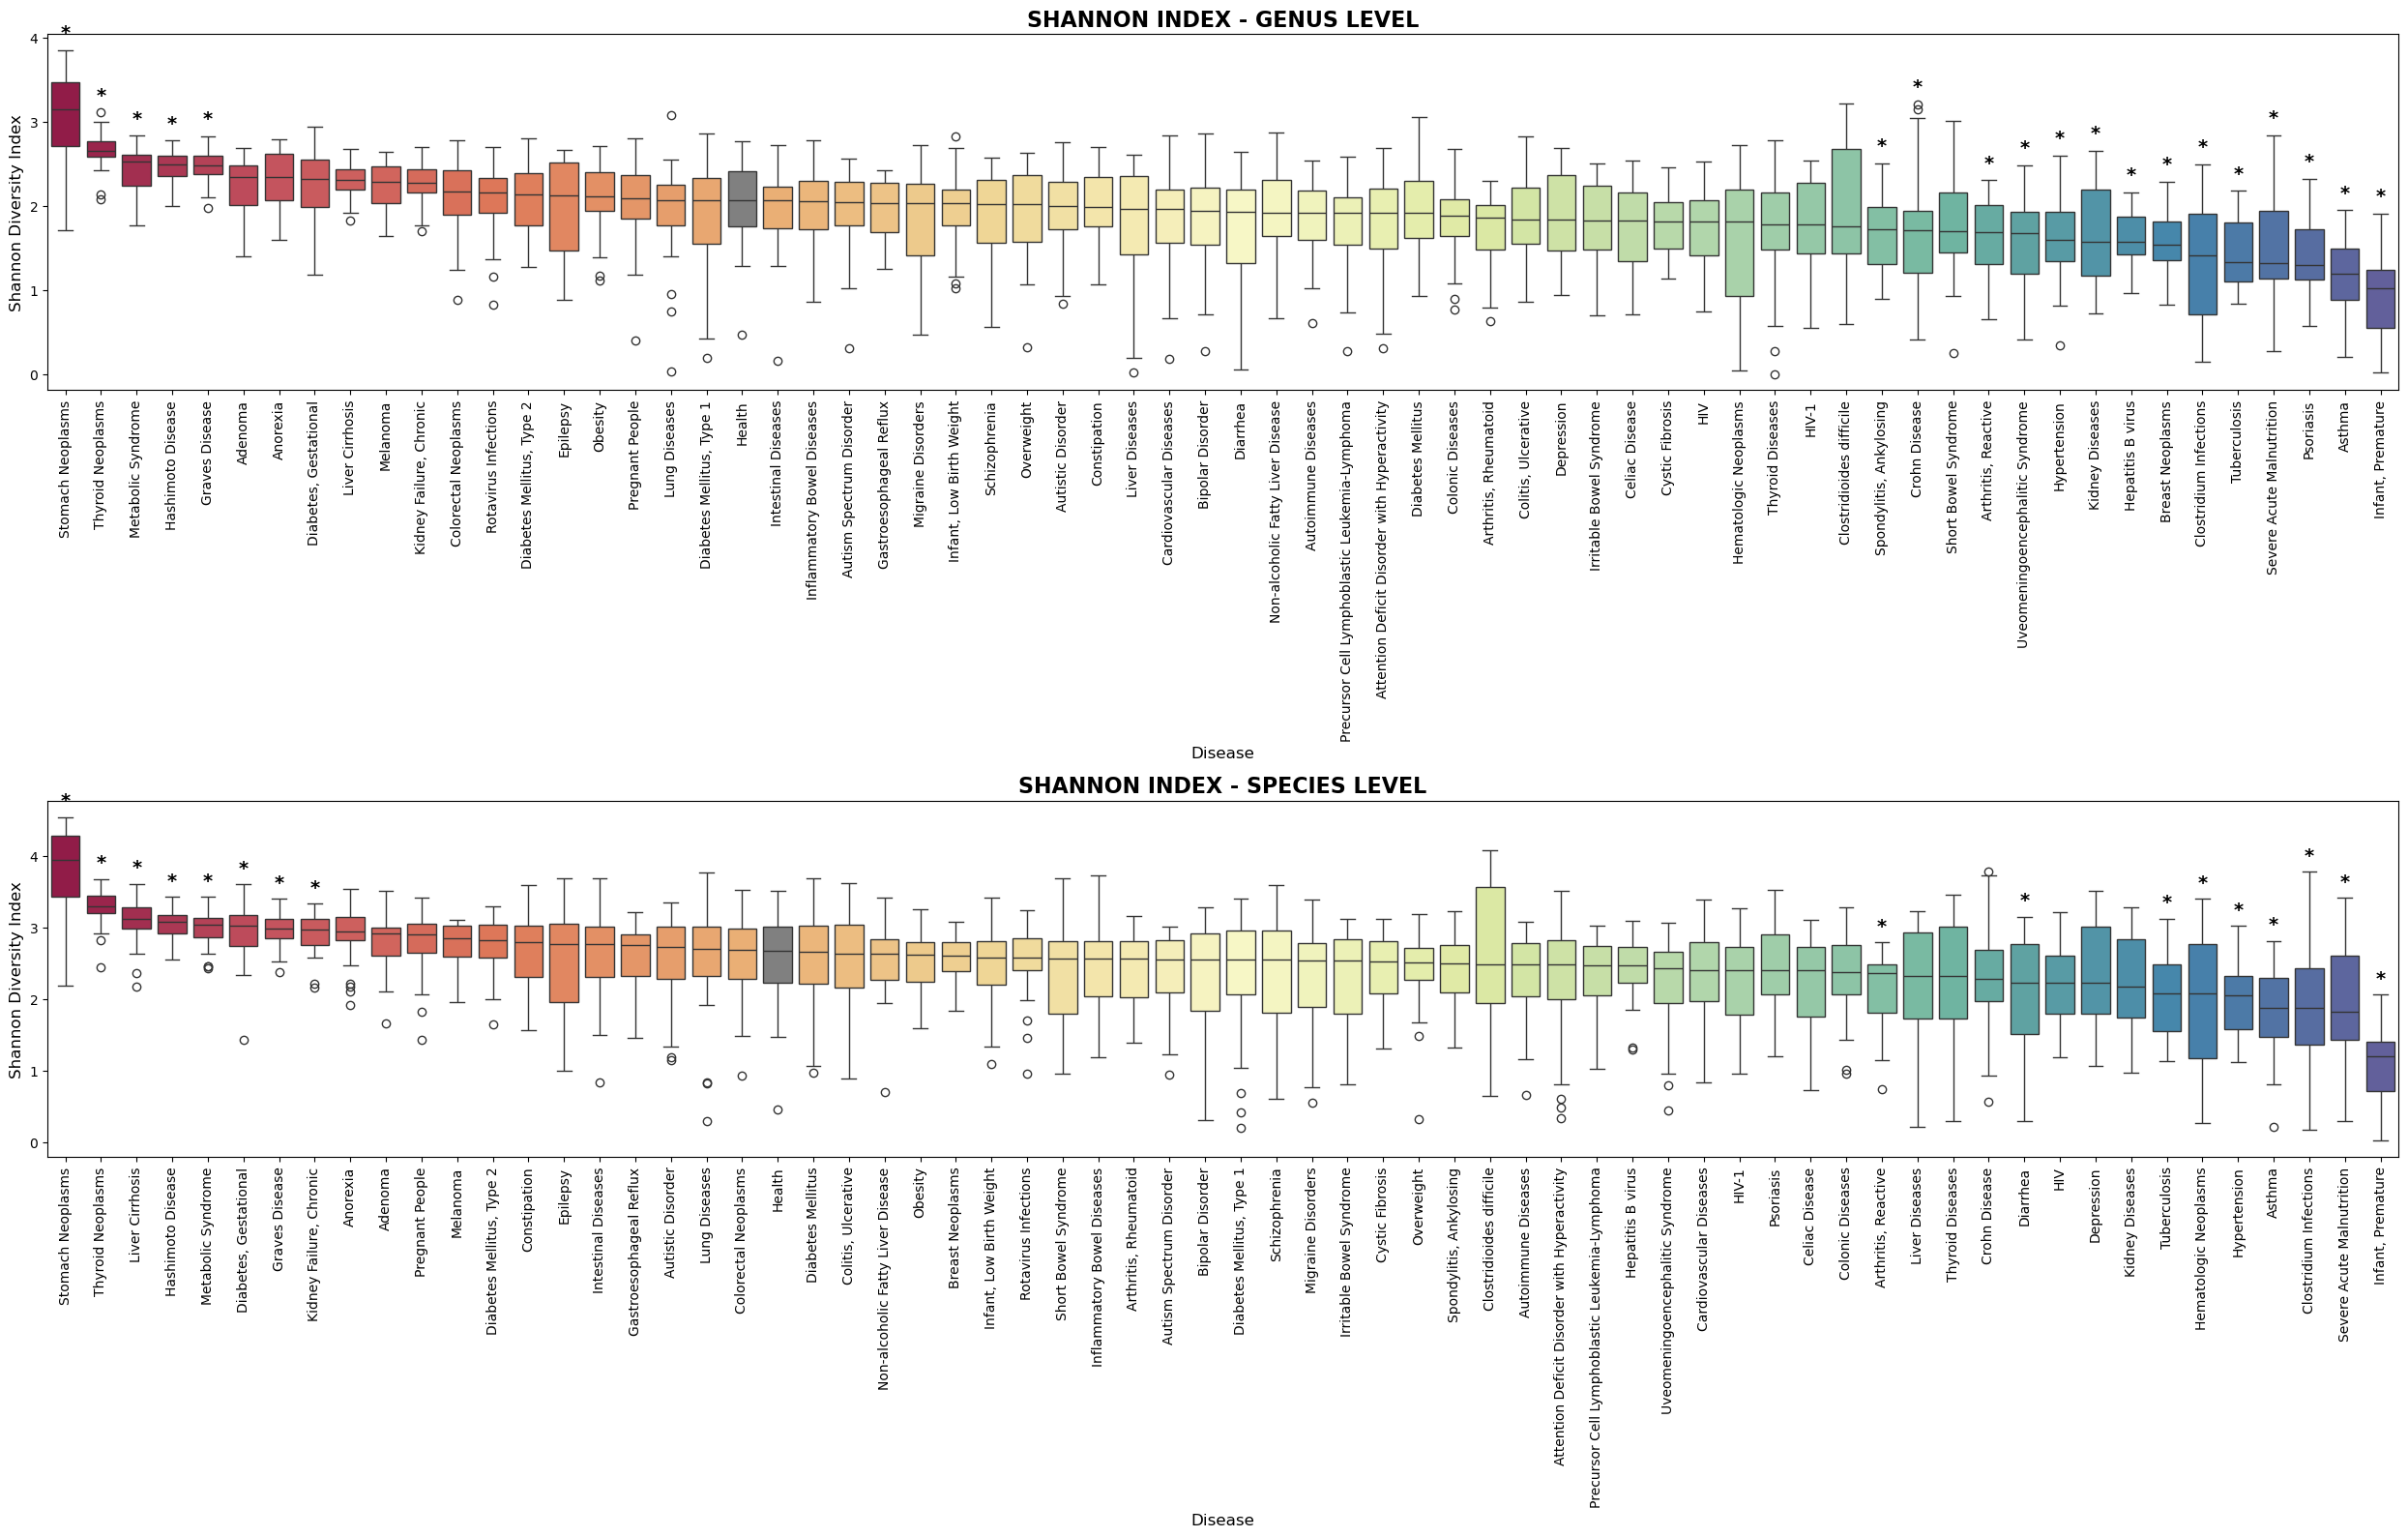

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# --------------------------
# Define healthy label
# --------------------------
healthy_label = 'D006262'
healthy_name = disease_dict.get(healthy_label, 'Healthy')

# --------------------------
# Prepare function to generate plot data
# --------------------------
def prepare_plot_data(df_downsampled, df_dunn_vs_healthy):
    df_plot = df_downsampled.copy()
    df_plot['disease_name'] = df_plot['disease'].map(disease_dict)

    if df_dunn_vs_healthy is not None:
        significant_diseases = df_dunn_vs_healthy.query("`Significant (FDR < 0.05)`")['Disease Code'].tolist()
        significant_names = [disease_dict.get(code, code) for code in significant_diseases]
    else:
        significant_names = []

    df_plot['significant'] = df_plot['disease_name'].isin(significant_names)

    ordered_names = (
        df_plot.groupby("disease_name")["shannon"]
        .median()
        .sort_values(ascending=False)
        .index
    )

    palette = sns.color_palette("Spectral", n_colors=len(ordered_names) - 1)
    color_dict = {}
    palette_idx = 0
    for name in ordered_names:
        if name == healthy_name:
            color_dict[name] = 'grey'
        else:
            color_dict[name] = palette[palette_idx]
            palette_idx += 1

    return df_plot, ordered_names, color_dict, significant_names

# --------------------------
# Prepare data for both levels
# --------------------------
df_plot_genus, ordered_names_genus, color_dict_genus, significant_genus = prepare_plot_data(df_downsampled_genus, df_dunn_vs_healthy_genus)
df_plot_species, ordered_names_species, color_dict_species, significant_species = prepare_plot_data(df_downsampled_species, df_dunn_vs_healthy_species)

# --------------------------
# Create subplots
# --------------------------
fig, axes = plt.subplots(2, 1, figsize=(25, 16), sharey=False)

# === GENUS LEVEL PLOT ===
sns.boxplot(
    data=df_plot_genus,
    x="disease_name",
    y="shannon",
    order=ordered_names_genus,
    hue="disease_name",
    palette=color_dict_genus,
    dodge=False,
    ax=axes[0],
    legend=False
)

axes[0].set_title("SHANNON INDEX - GENUS LEVEL", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Disease", fontsize=12)
axes[0].set_ylabel("Shannon Diversity Index", fontsize=12)
axes[0].tick_params(axis='x', rotation=90)
axes[0].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

for i, name in enumerate(ordered_names_genus):
    if name in significant_genus:
        max_val = df_plot_genus[df_plot_genus['disease_name'] == name]['shannon'].max()
        axes[0].text(i, max_val + 0.1, "*", ha='center', va='bottom', fontsize=14, fontweight='bold', color='black')

# === SPECIES LEVEL PLOT ===
sns.boxplot(
    data=df_plot_species,
    x="disease_name",
    y="shannon",
    order=ordered_names_species,
    hue="disease_name",
    palette=color_dict_species,
    dodge=False,
    ax=axes[1],
    legend=False
)

axes[1].set_title("SHANNON INDEX - SPECIES LEVEL", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Disease", fontsize=12)
axes[1].set_ylabel("Shannon Diversity Index", fontsize=12)
axes[1].tick_params(axis='x', rotation=90)
axes[1].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

for i, name in enumerate(ordered_names_species):
    if name in significant_species:
        max_val = df_plot_species[df_plot_species['disease_name'] == name]['shannon'].max()
        axes[1].text(i, max_val + 0.1, "*", ha='center', va='bottom', fontsize=14, fontweight='bold', color='black')

# --------------------------
# Final formatting
# --------------------------
plt.tight_layout()
plt.show()


/tmp/slurm.4355529/ipykernel_2228844/1001745623.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/slurm.4355529/ipykernel_2228844/1001745623.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


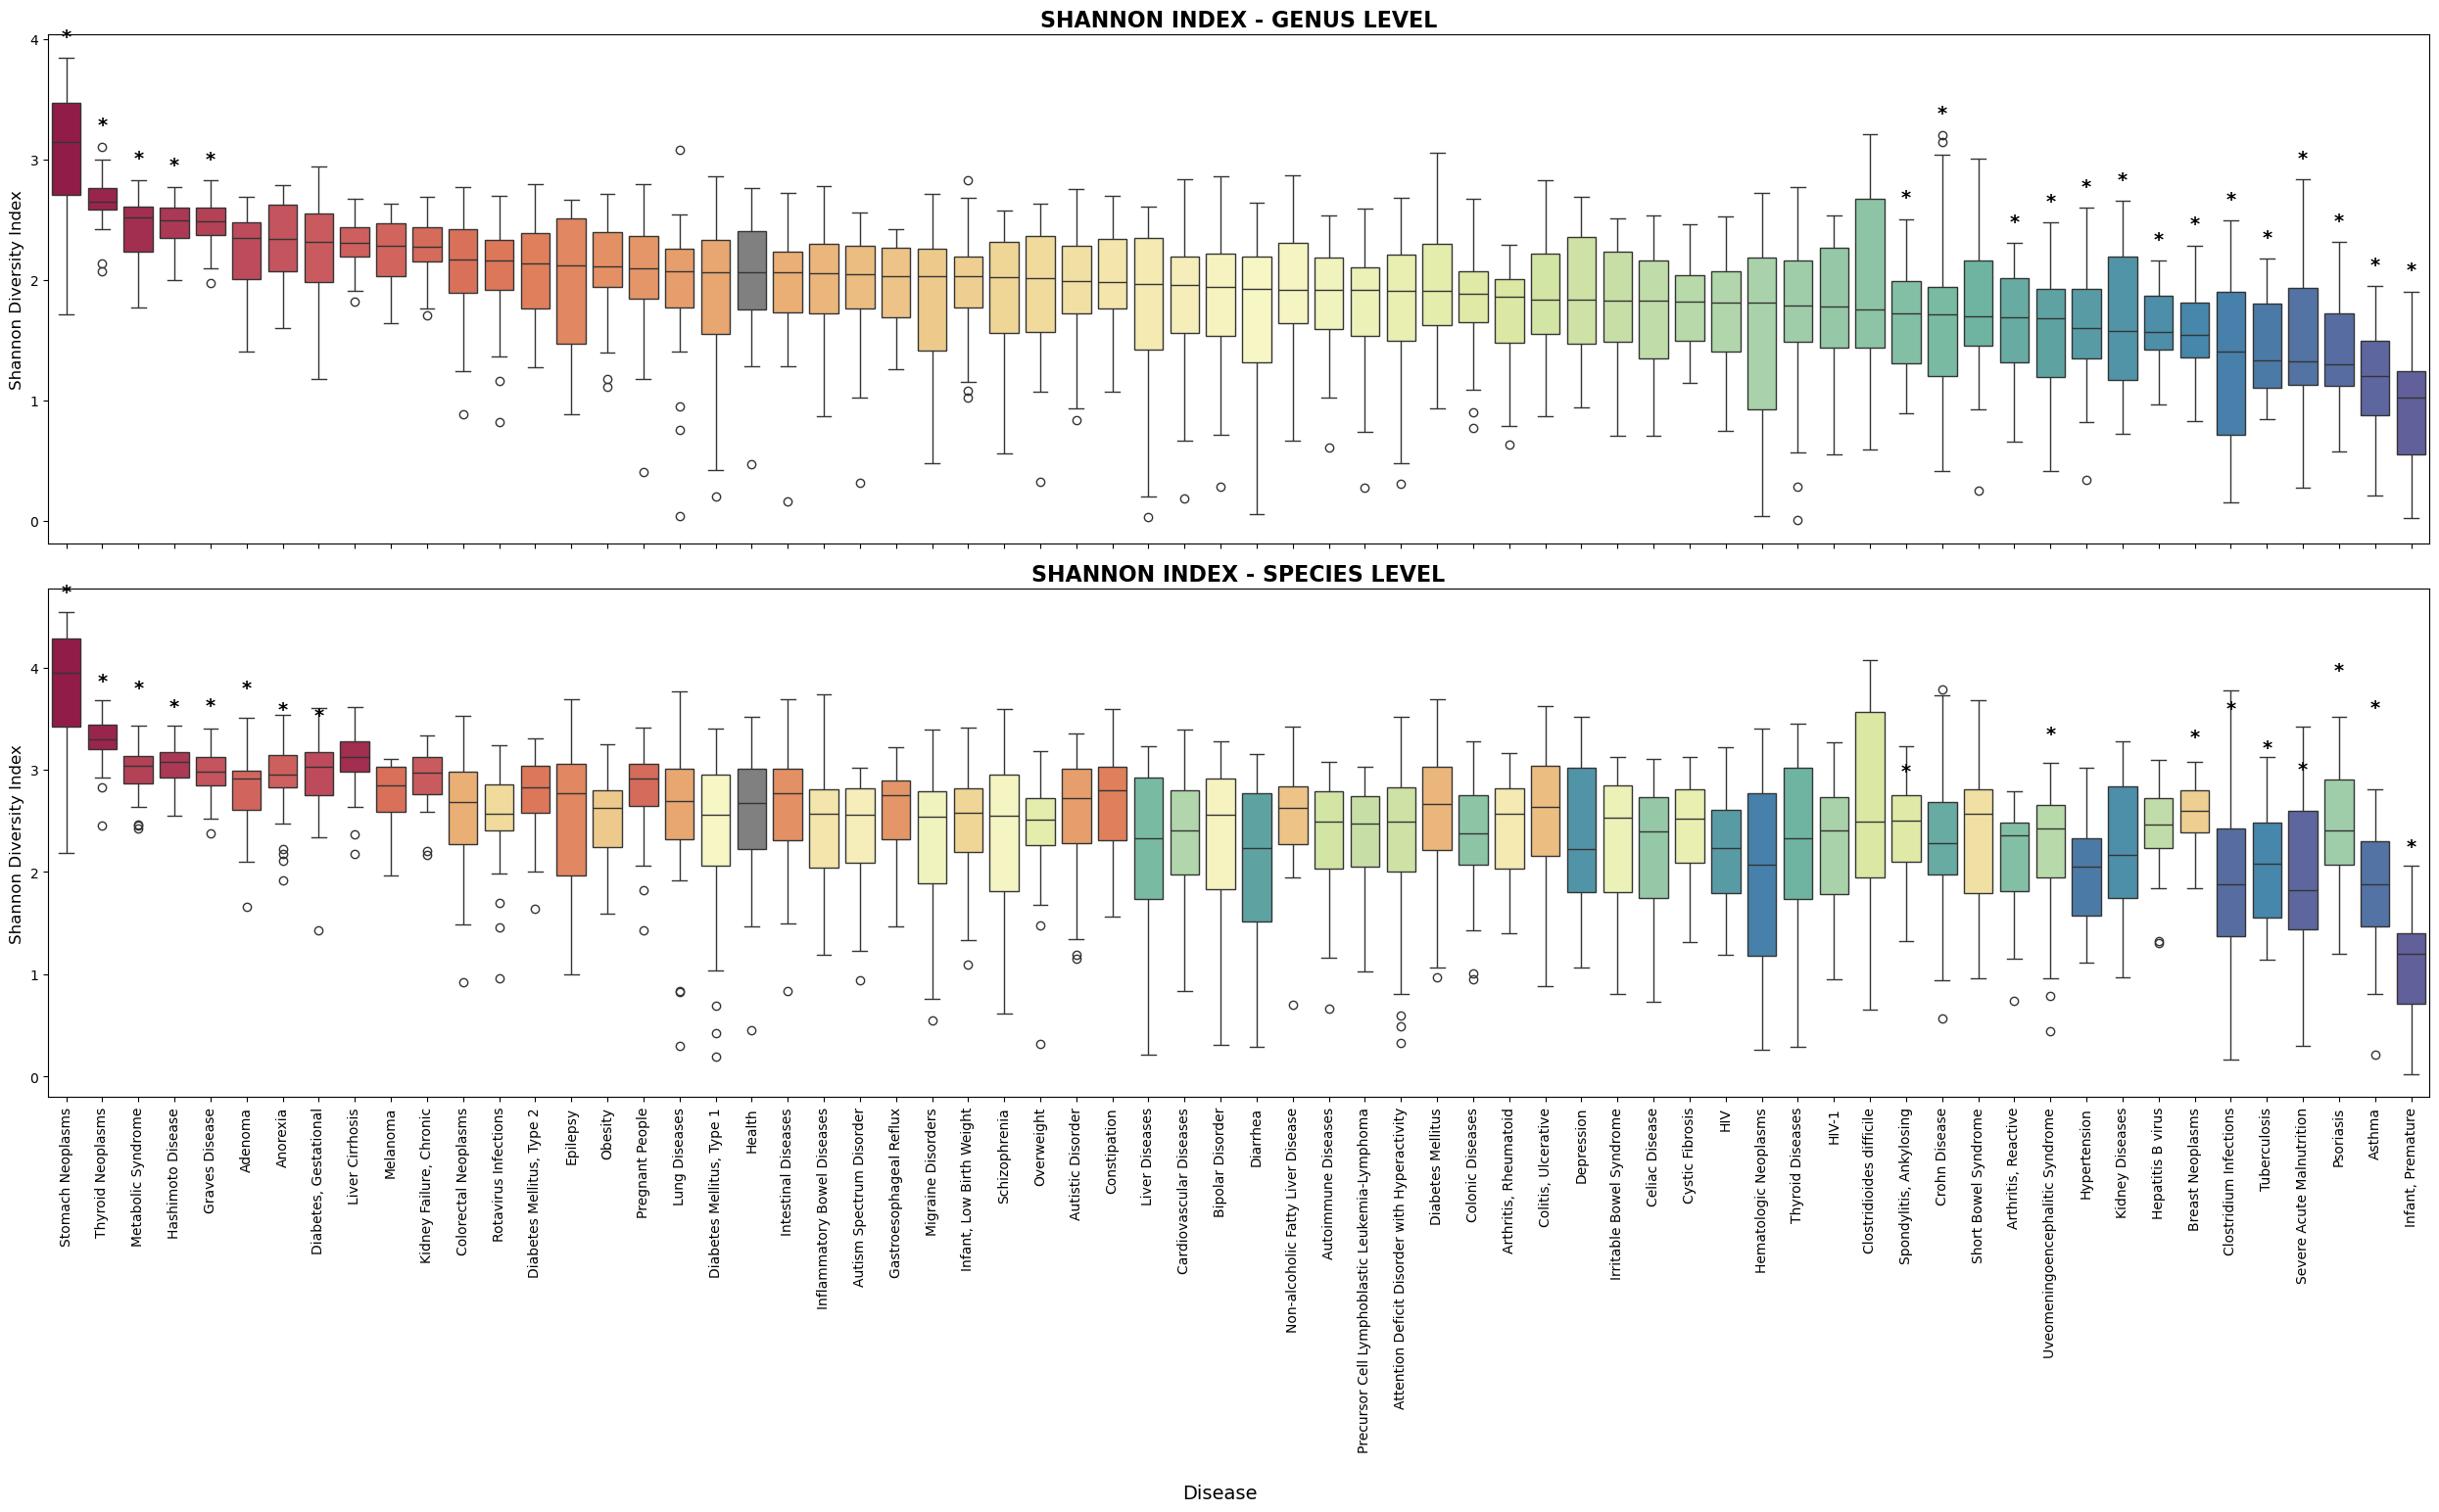

In [50]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# --------------------------
# Define healthy label
# --------------------------
healthy_label = 'D006262'
healthy_name = disease_dict.get(healthy_label, 'Healthy')

# --------------------------
# Prepare function to generate plot data
# --------------------------
def prepare_plot_data(df_downsampled, df_dunn_vs_healthy):
    df_plot = df_downsampled.copy()
    df_plot['disease_name'] = df_plot['disease'].map(disease_dict)

    if df_dunn_vs_healthy is not None:
        significant_diseases = df_dunn_vs_healthy.query("`Significant (FDR < 0.05)`")['Disease Code'].tolist()
        significant_names = [disease_dict.get(code, code) for code in significant_diseases]
    else:
        significant_names = []

    df_plot['significant'] = df_plot['disease_name'].isin(significant_names)

    ordered_names = (
        df_plot.groupby("disease_name")["shannon"]
        .median()
        .sort_values(ascending=False)
        .index
    )

    palette = sns.color_palette("Spectral", n_colors=len(ordered_names) - 1)
    color_dict = {}
    palette_idx = 0
    for name in ordered_names:
        if name == healthy_name:
            color_dict[name] = 'grey'
        else:
            color_dict[name] = palette[palette_idx]
            palette_idx += 1

    return df_plot, ordered_names, color_dict, significant_names

# --------------------------
# Prepare data for both levels
# --------------------------
df_plot_genus, ordered_names_genus, color_dict_genus, significant_genus = prepare_plot_data(df_downsampled_genus, df_dunn_vs_healthy_genus)
df_plot_species, ordered_names_species, color_dict_species, significant_species = prepare_plot_data(df_downsampled_species, df_dunn_vs_healthy_species)

# --------------------------
# Create subplots with shared x-axis
# --------------------------
fig, axes = plt.subplots(2, 1, figsize=(25, 16), sharex=True)

# === GENUS LEVEL PLOT ===
sns.boxplot(
    data=df_plot_genus,
    x="disease_name",
    y="shannon",
    order=ordered_names_genus,
    palette=color_dict_genus,
    dodge=False,
    ax=axes[0],
)

axes[0].set_title("SHANNON INDEX - GENUS LEVEL", fontsize=16, fontweight='bold')
axes[0].set_ylabel("Shannon Diversity Index", fontsize=12)
axes[0].tick_params(axis='x', rotation=90)
axes[0].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
axes[0].set_xlabel(None)

for i, name in enumerate(ordered_names_genus):
    if name in significant_genus:
        max_val = df_plot_genus[df_plot_genus['disease_name'] == name]['shannon'].max()
        axes[0].text(i, max_val + 0.1, "*", ha='center', va='bottom', fontsize=14, fontweight='bold', color='black')

# === SPECIES LEVEL PLOT ===
sns.boxplot(
    data=df_plot_species,
    x="disease_name",
    y="shannon",
    order=ordered_names_species,
    palette=color_dict_species,
    dodge=False,
    ax=axes[1],
)

axes[1].set_title("SHANNON INDEX - SPECIES LEVEL", fontsize=16, fontweight='bold')
axes[1].set_ylabel("Shannon Diversity Index", fontsize=12)
axes[1].tick_params(axis='x', rotation=90)
axes[1].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
axes[1].set_xlabel(None)

for i, name in enumerate(ordered_names_species):
    if name in significant_species:
        max_val = df_plot_species[df_plot_species['disease_name'] == name]['shannon'].max()
        axes[1].text(i, max_val + 0.1, "*", ha='center', va='bottom', fontsize=14, fontweight='bold', color='black')

# --------------------------
# Final formatting: Shared x-label
# --------------------------
fig.text(0.5, 0.04, "Disease", ha='center', fontsize=14)
plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()


/tmp/slurm.4355529/ipykernel_2228844/3801016691.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


/tmp/slurm.4355529/ipykernel_2228844/3801016691.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


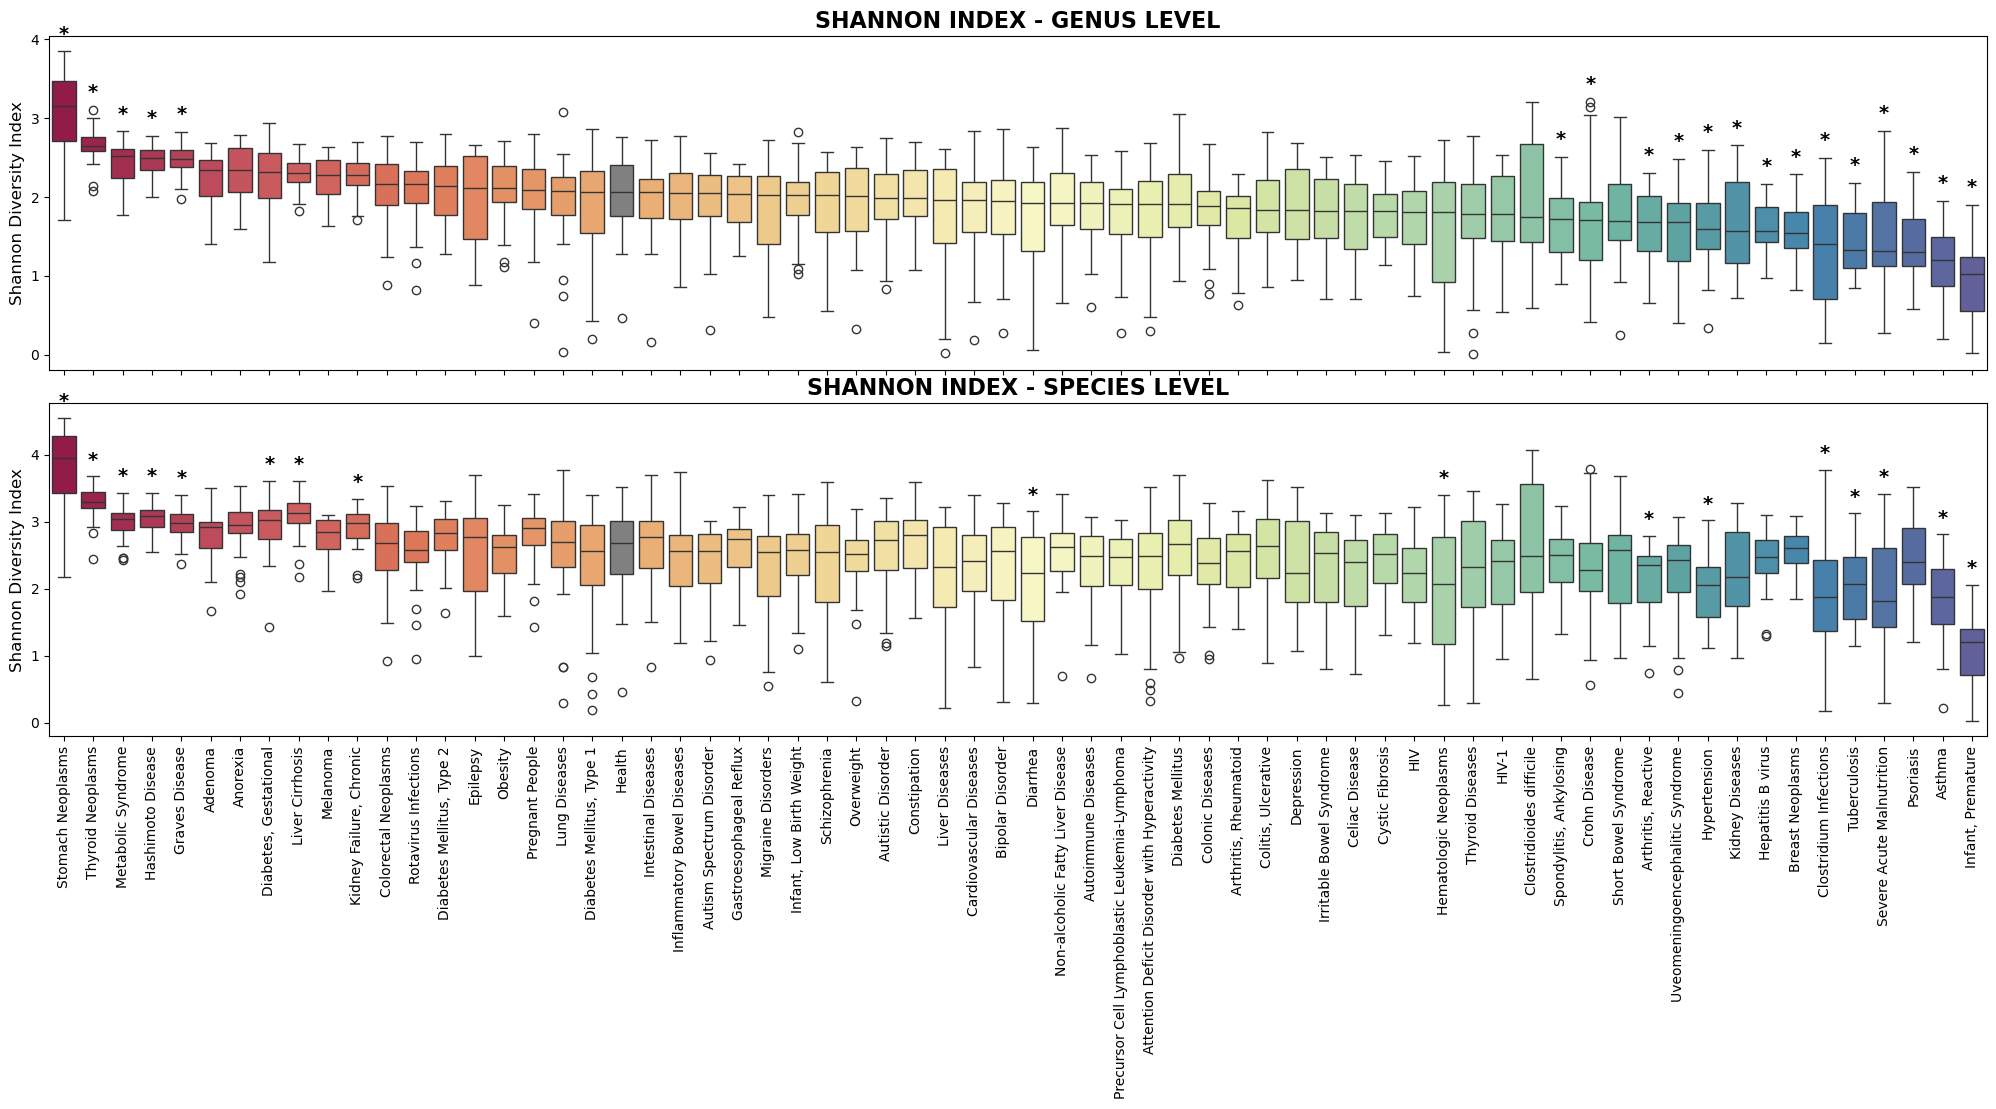

In [51]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# --------------------------
# Define healthy label
# --------------------------
healthy_label = 'D006262'
healthy_name = disease_dict.get(healthy_label, 'Healthy')

# --------------------------
# Prepare function to generate plot data
# --------------------------
def prepare_plot_data(df_downsampled, df_dunn_vs_healthy):
    df_plot = df_downsampled.copy()
    df_plot['disease_name'] = df_plot['disease'].map(disease_dict)

    if df_dunn_vs_healthy is not None:
        significant_diseases = df_dunn_vs_healthy.query("`Significant (FDR < 0.05)`")['Disease Code'].tolist()
        significant_names = [disease_dict.get(code, code) for code in significant_diseases]
    else:
        significant_names = []

    df_plot['significant'] = df_plot['disease_name'].isin(significant_names)

    ordered_names = (
        df_plot.groupby("disease_name")["shannon"]
        .median()
        .sort_values(ascending=False)
        .index
    )

    palette = sns.color_palette("Spectral", n_colors=len(ordered_names) - 1)
    color_dict = {}
    palette_idx = 0
    for name in ordered_names:
        if name == healthy_name:
            color_dict[name] = 'grey'
        else:
            color_dict[name] = palette[palette_idx]
            palette_idx += 1

    return df_plot, ordered_names, color_dict, significant_names

# --------------------------
# Prepare genus-level data
# --------------------------
df_plot_genus, ordered_names_genus, color_dict_genus, significant_genus = prepare_plot_data(
    df_downsampled_genus, df_dunn_vs_healthy_genus
)

# --------------------------
# Prepare species-level data, reuse genus order & colors
# --------------------------
df_plot_species, _, _, significant_species = prepare_plot_data(
    df_downsampled_species, df_dunn_vs_healthy_species
)
ordered_names_species = ordered_names_genus
color_dict_species = color_dict_genus

# --------------------------
# Create subplots with shared x-axis
# --------------------------
fig, axes = plt.subplots(2, 1, figsize=(25, 10), sharex=True)

# === GENUS LEVEL PLOT ===
sns.boxplot(
    data=df_plot_genus,
    x="disease_name",
    y="shannon",
    order=ordered_names_genus,
    palette=color_dict_genus,
    dodge=False,
    ax=axes[0],
)

axes[0].set_title("SHANNON INDEX - GENUS LEVEL", fontsize=16, fontweight='bold')
axes[0].set_ylabel("Shannon Diversity Index", fontsize=12)
axes[0].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
axes[0].tick_params(axis='x', rotation=90, labelbottom=False)  # ✅ hides top x-labels only

for i, name in enumerate(ordered_names_genus):
    if name in significant_genus:
        max_val = df_plot_genus[df_plot_genus['disease_name'] == name]['shannon'].max()
        axes[0].text(i, max_val + 0.1, "*", ha='center', va='bottom', fontsize=14, fontweight='bold', color='black')

# === SPECIES LEVEL PLOT ===
sns.boxplot(
    data=df_plot_species,
    x="disease_name",
    y="shannon",
    order=ordered_names_species,
    palette=color_dict_species,
    dodge=False,
    ax=axes[1],
)

axes[1].set_title("SHANNON INDEX - SPECIES LEVEL", fontsize=16, fontweight='bold')
axes[1].set_xlabel(None)  # ✅ Remove subplot x-label to avoid duplication
axes[1].set_ylabel("Shannon Diversity Index", fontsize=12)
axes[1].tick_params(axis='x', rotation=90)
axes[1].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

for i, name in enumerate(ordered_names_species):
    if name in significant_species:
        max_val = df_plot_species[df_plot_species['disease_name'] == name]['shannon'].max()
        axes[1].text(i, max_val + 0.1, "*", ha='center', va='bottom', fontsize=14, fontweight='bold', color='black')

# --------------------------
# Final formatting: Adjust layout and add shared x-label
# --------------------------
plt.subplots_adjust(hspace=0.1, bottom=0.18)  # Adjust spacing

plt.show()


/tmp/slurm.4355529/ipykernel_2228844/4024600074.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


/tmp/slurm.4355529/ipykernel_2228844/4024600074.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


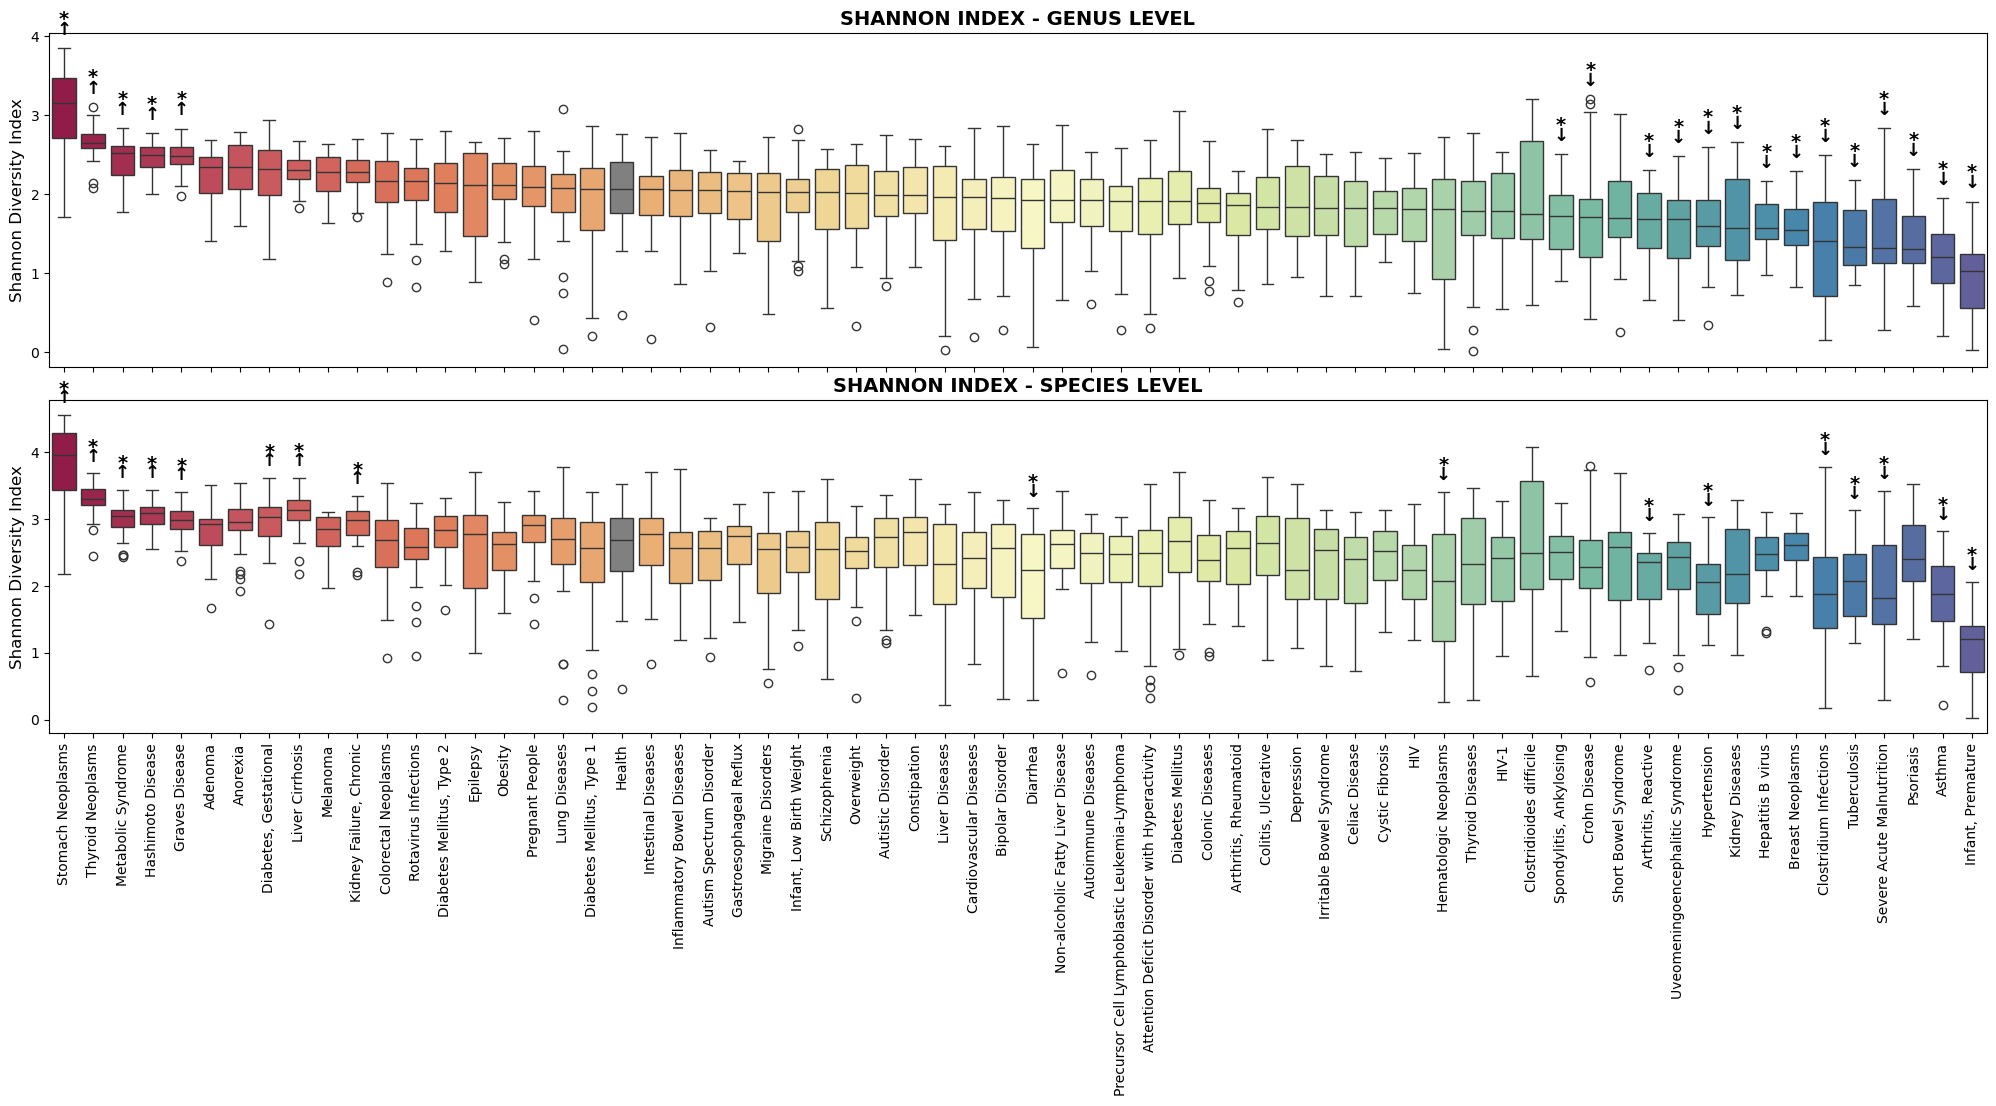

In [62]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# --------------------------
# Define healthy label
# --------------------------
healthy_label = 'D006262'
healthy_name = disease_dict.get(healthy_label, 'Healthy')

# --------------------------
# Prepare function to generate plot data
# --------------------------
def prepare_plot_data(df_downsampled, df_dunn_vs_healthy):
    df_plot = df_downsampled.copy()
    df_plot['disease_name'] = df_plot['disease'].map(disease_dict)

    if df_dunn_vs_healthy is not None:
        significant_diseases = df_dunn_vs_healthy.query("`Significant (FDR < 0.05)`")['Disease Code'].tolist()
        significant_names = [disease_dict.get(code, code) for code in significant_diseases]
    else:
        significant_names = []

    df_plot['significant'] = df_plot['disease_name'].isin(significant_names)

    ordered_names = (
        df_plot.groupby("disease_name")["shannon"]
        .median()
        .sort_values(ascending=False)
        .index
    )

    palette = sns.color_palette("Spectral", n_colors=len(ordered_names) - 1)
    color_dict = {}
    palette_idx = 0
    for name in ordered_names:
        if name == healthy_name:
            color_dict[name] = 'grey'
        else:
            color_dict[name] = palette[palette_idx]
            palette_idx += 1

    return df_plot, ordered_names, color_dict, significant_names

# --------------------------
# Prepare genus-level data
# --------------------------
df_plot_genus, ordered_names_genus, color_dict_genus, significant_genus = prepare_plot_data(
    df_downsampled_genus, df_dunn_vs_healthy_genus
)

# --------------------------
# Prepare species-level data, reuse genus order & colors
# --------------------------
df_plot_species, _, _, significant_species = prepare_plot_data(
    df_downsampled_species, df_dunn_vs_healthy_species
)
ordered_names_species = ordered_names_genus
color_dict_species = color_dict_genus

# --------------------------
# Healthy medians for arrow direction
# --------------------------
healthy_median_genus = df_plot_genus[df_plot_genus['disease'] == healthy_label]['shannon'].median()
healthy_median_species = df_plot_species[df_plot_species['disease'] == healthy_label]['shannon'].median()

# --------------------------
# Create subplots with shared x-axis
# --------------------------
fig, axes = plt.subplots(2, 1, figsize=(25, 10), sharex=True)

# === GENUS LEVEL PLOT ===
sns.boxplot(
    data=df_plot_genus,
    x="disease_name",
    y="shannon",
    order=ordered_names_genus,
    palette=color_dict_genus,
    dodge=False,
    ax=axes[0],
)

axes[0].set_title("SHANNON INDEX - GENUS LEVEL", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Shannon Diversity Index", fontsize=12)
axes[0].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
axes[0].tick_params(axis='x', rotation=90, labelbottom=False)

for i, name in enumerate(ordered_names_genus):
    if name in significant_genus and name != healthy_name:
        max_val = df_plot_genus[df_plot_genus['disease_name'] == name]['shannon'].max()
        # asterisk
        axes[0].text(i, max_val + 0.25, "*", ha='center', va='bottom',
                     fontsize=14, fontweight='bold', color='black')
        # arrow: up if disease median > healthy median, else down
        med_val = df_plot_genus[df_plot_genus['disease_name'] == name]['shannon'].median()
        arrow = "↑" if med_val > healthy_median_genus else "↓"
        axes[0].text(i, max_val + 0.12, arrow, ha='center', va='bottom',
                     fontsize=13, fontweight='bold', color='black')

# === SPECIES LEVEL PLOT ===
sns.boxplot(
    data=df_plot_species,
    x="disease_name",
    y="shannon",
    order=ordered_names_species,
    palette=color_dict_species,
    dodge=False,
    ax=axes[1],
)

axes[1].set_title("SHANNON INDEX - SPECIES LEVEL", fontsize=14, fontweight='bold')
axes[1].set_xlabel(None)
axes[1].set_ylabel("Shannon Diversity Index", fontsize=12)
axes[1].tick_params(axis='x', rotation=90)
axes[1].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

for i, name in enumerate(ordered_names_species):
    if name in significant_species and name != healthy_name:
        max_val = df_plot_species[df_plot_species['disease_name'] == name]['shannon'].max()
        # asterisk
        axes[1].text(i, max_val + 0.25, "*", ha='center', va='bottom',
                     fontsize=14, fontweight='bold', color='black')
        # arrow direction vs healthy
        med_val = df_plot_species[df_plot_species['disease_name'] == name]['shannon'].median()
        arrow = "↑" if med_val > healthy_median_species else "↓"
        axes[1].text(i, max_val + 0.12, arrow, ha='center', va='bottom',
                     fontsize=13, fontweight='bold', color='black')

# --------------------------
# Final formatting
# --------------------------
plt.subplots_adjust(hspace=0.1, bottom=0.18)
plt.show()


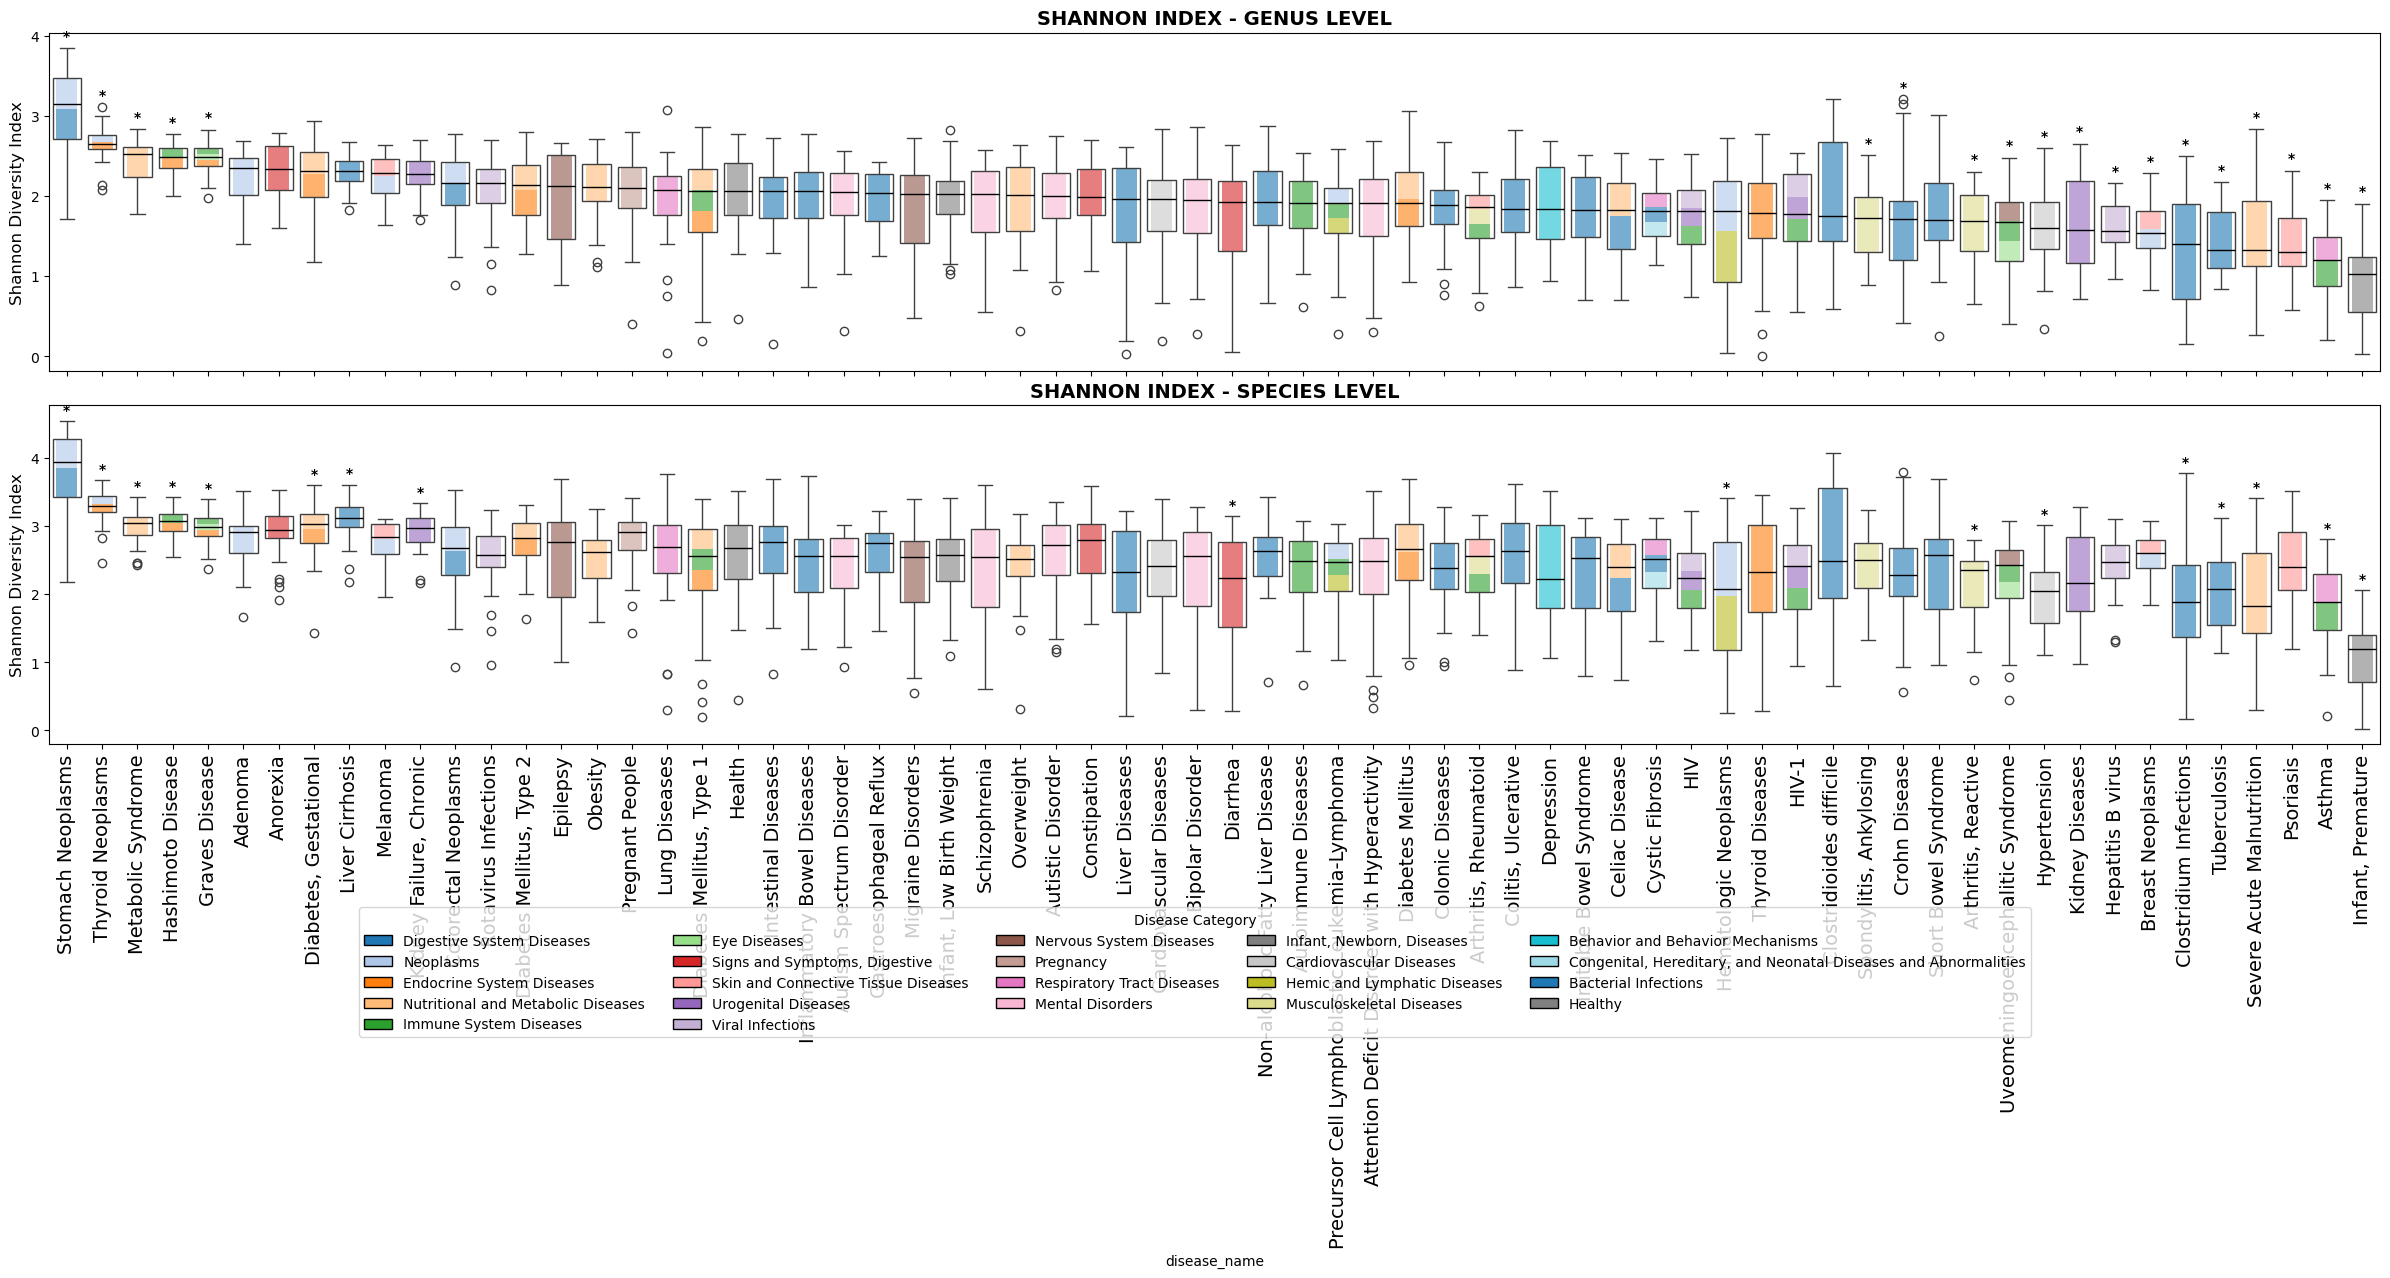

In [56]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.patches import Patch, Rectangle
import json

# --------------------------
# Load disease categories
# --------------------------
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/disease_classification.json", "r") as f:
    disease_category_by_id = json.load(f)

# --------------------------
# Define healthy label
# --------------------------
healthy_label = 'D006262'
healthy_name = disease_dict.get(healthy_label, 'Healthy')

# --------------------------
# Normalize category names
# --------------------------
def _norm_cat(x):
    if isinstance(x, list):
        return " / ".join(sorted(map(str, set(x))))
    if x is None:
        return "Unknown"
    return str(x)

# --------------------------
# Prepare plotting dataframe
# --------------------------
def prepare_plot_data(df_downsampled, df_dunn_vs_healthy):
    df_plot = df_downsampled.copy()

    df_plot['disease_name'] = df_plot['disease'].map(disease_dict)
    df_plot['category'] = df_plot['disease'].map(disease_category_by_id).apply(_norm_cat)

    df_plot.loc[df_plot['disease'] == healthy_label, 'category'] = 'Healthy'

    if df_dunn_vs_healthy is not None:
        sig_codes = df_dunn_vs_healthy.query("`Significant (FDR < 0.05)`")['Disease Code'].tolist()
        sig_names = [disease_dict.get(code, code) for code in sig_codes]
    else:
        sig_names = []
    df_plot['significant'] = df_plot['disease_name'].isin(sig_names)

    ordered_names = (
        df_plot.groupby("disease_name")["shannon"]
        .median()
        .sort_values(ascending=False)
        .index
    )

    return df_plot, ordered_names, sig_names

# --------------------------
# Build category palette
# --------------------------
def build_category_palette(df_plot, ordered_names):
    disease_to_cat = (
        df_plot.drop_duplicates(['disease_name'])[['disease_name', 'category']]
        .set_index('disease_name')['category']
        .to_dict()
    )

    unique_cats = []
    for name in ordered_names:
        cat = disease_to_cat.get(name)
        if cat:
            for sub_c in cat.split(" / "):
                if sub_c not in unique_cats:
                    unique_cats.append(sub_c)

    if 'Healthy' in unique_cats:
        unique_cats = [c for c in unique_cats if c != 'Healthy'] + ['Healthy']

    base_palette = sns.color_palette("tab20", n_colors=max(3, len(unique_cats)))
    cat_to_color = {c: base_palette[i % len(base_palette)] for i, c in enumerate(unique_cats)}
    cat_to_color['Healthy'] = 'grey'

    legend_handles = [Patch(facecolor=cat_to_color[c], edgecolor='black', label=c) for c in unique_cats]

    return cat_to_color, legend_handles

# --------------------------
# Draw multi-color boxes
# --------------------------
def draw_multicolor_boxes(ax, df_plot, order, cat_to_color):
    box_width = 0.6  # width of the fill inside the box outlines

    for i, name in enumerate(order):
        categories = df_plot.loc[df_plot['disease_name'] == name, 'category'].iloc[0].split(" / ")
        q1 = df_plot.loc[df_plot['disease_name'] == name, 'shannon'].quantile(0.25)
        q3 = df_plot.loc[df_plot['disease_name'] == name, 'shannon'].quantile(0.75)

        if len(categories) == 1:
            rect = Rectangle((i - box_width/2, q1),
                             box_width, q3 - q1,
                             facecolor=cat_to_color.get(categories[0], "grey"),
                             edgecolor='none', alpha=0.6, zorder=2)
            ax.add_patch(rect)
        else:
            # Split vertically (stacked)
            split_height = (q3 - q1) / len(categories)
            for j, cat in enumerate(categories):
                rect = Rectangle((i - box_width/2, q1 + j * split_height),
                                 box_width, split_height,
                                 facecolor=cat_to_color.get(cat, "grey"),
                                 edgecolor='none', alpha=0.6, zorder=2)
                ax.add_patch(rect)

# --------------------------
# Prepare data
# --------------------------
df_plot_genus, ordered_names_genus, significant_genus = prepare_plot_data(
    df_downsampled_genus, df_dunn_vs_healthy_genus
)
cat_to_color, legend_handles = build_category_palette(df_plot_genus, ordered_names_genus)

df_plot_species, _, significant_species = prepare_plot_data(
    df_downsampled_species, df_dunn_vs_healthy_species
)
ordered_names_species = ordered_names_genus

# --------------------------
# Safe figure width
# --------------------------
n_diseases = len(ordered_names_genus)
max_width_inch = 24
min_width_inch = 12
width_per_disease = 0.4

fig_width = min(max_width_inch, max(min_width_inch, n_diseases * width_per_disease))
fig, axes = plt.subplots(2, 1, figsize=(fig_width, 10), sharex=True)

# === GENUS LEVEL ===
sns.boxplot(
    data=df_plot_genus,
    x="disease_name",
    y="shannon",
    order=ordered_names_genus,
    showcaps=True,
    boxprops={'facecolor': 'none', 'zorder': 3},
    whiskerprops={'zorder': 3},
    medianprops={'zorder': 4, 'color': 'black'},
    dodge=False,
    ax=axes[0],
)
draw_multicolor_boxes(axes[0], df_plot_genus, ordered_names_genus, cat_to_color)
axes[0].set_title("SHANNON INDEX - GENUS LEVEL", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Shannon Diversity Index", fontsize=12)
axes[0].tick_params(axis='x', rotation=90, labelsize=14, labelbottom=False)
axes[0].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
for i, name in enumerate(ordered_names_genus):
    if name in significant_genus:
        max_val = df_plot_genus.loc[df_plot_genus['disease_name'] == name, 'shannon'].max()
        axes[0].text(i, max_val + 0.1, "*", ha='center', fontsize=10, fontweight='bold')

# === SPECIES LEVEL ===
sns.boxplot(
    data=df_plot_species,
    x="disease_name",
    y="shannon",
    order=ordered_names_species,
    showcaps=True,
    boxprops={'facecolor': 'none', 'zorder': 3},
    whiskerprops={'zorder': 3},
    medianprops={'zorder': 4, 'color': 'black'},
    dodge=False,
    ax=axes[1],
)
draw_multicolor_boxes(axes[1], df_plot_species, ordered_names_species, cat_to_color)
axes[1].set_title("SHANNON INDEX - SPECIES LEVEL", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Shannon Diversity Index", fontsize=12)
axes[1].tick_params(axis='x', rotation=90, labelsize=14)
axes[1].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
for i, name in enumerate(ordered_names_species):
    if name in significant_species:
        max_val = df_plot_species.loc[df_plot_species['disease_name'] == name, 'shannon'].max()
        axes[1].text(i, max_val + 0.1, "*", ha='center', fontsize=10, fontweight='bold')

# --------------------------
# Legend at bottom
# --------------------------
plt.tight_layout()
fig.legend(handles=legend_handles, title="Disease Category",
           loc='lower center', bbox_to_anchor=(0.5, -0.05),
           ncol=5, frameon=True)

plt.subplots_adjust(hspace=0.1, bottom=0.25)
plt.show()


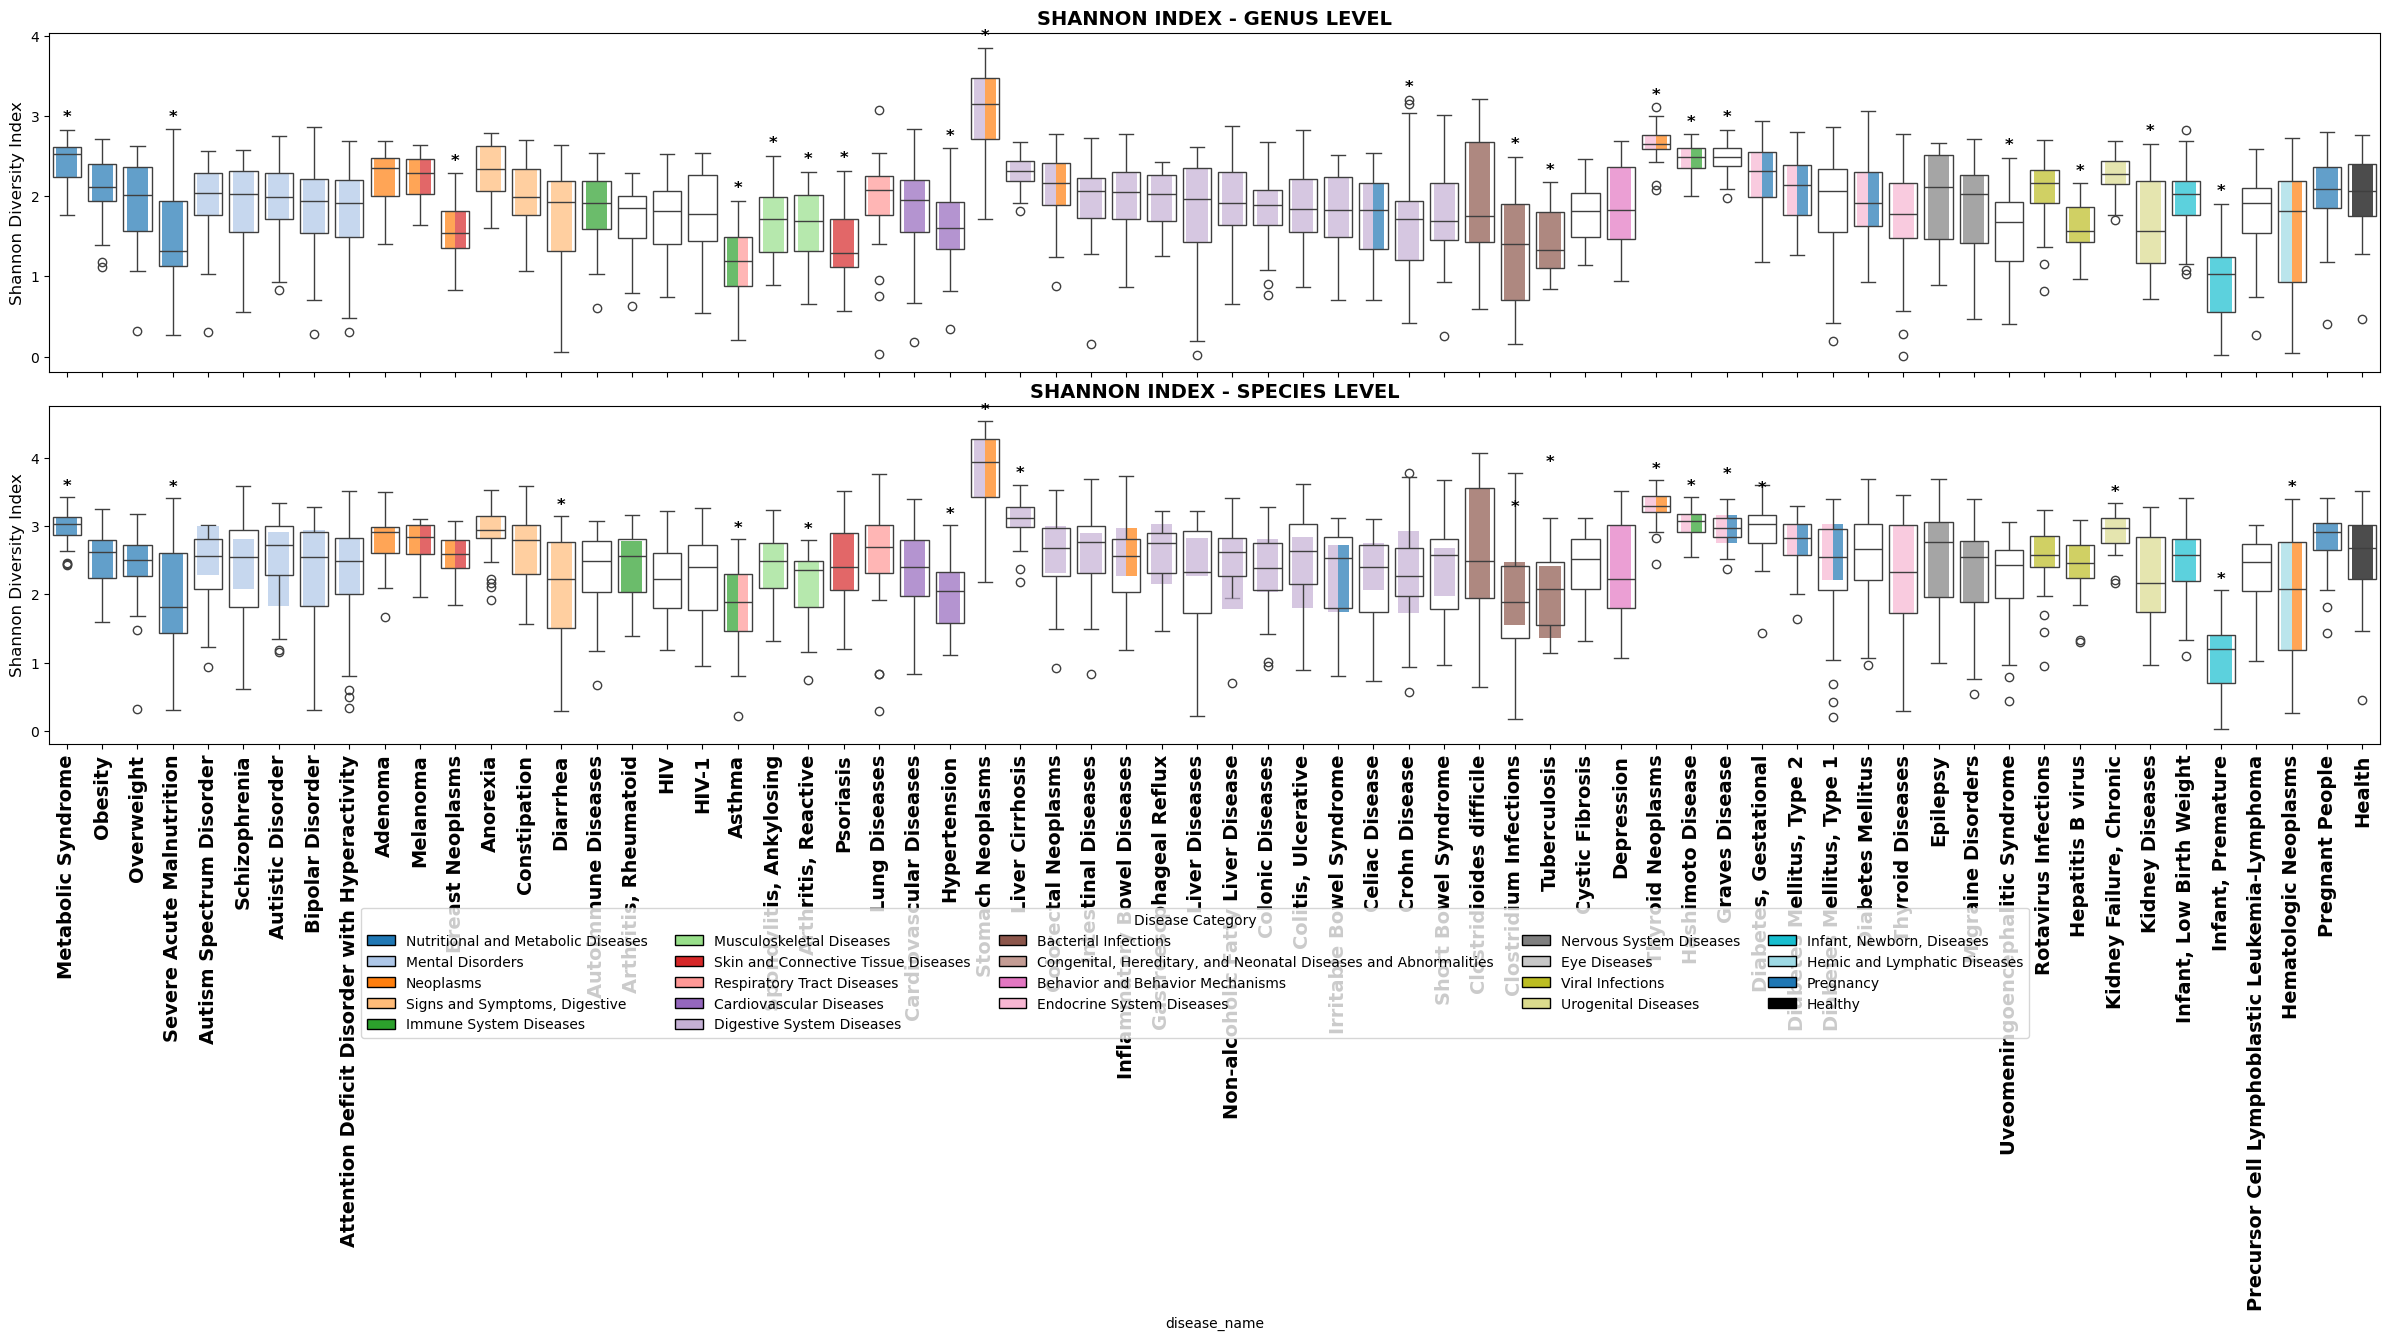

In [58]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.patches import Patch, Rectangle
import numpy as np
import json

# --------------------------
# Load disease categories
# --------------------------
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/disease_classification.json", "r") as f:
    disease_category_by_id = json.load(f)

# --------------------------
# Define healthy label
# --------------------------
healthy_label = 'D006262'
healthy_name = disease_dict.get(healthy_label, 'Healthy')

# --------------------------
# Normalize category names
# --------------------------
def _norm_cat(x):
    """Convert list categories to string, handle None, keep string as is."""
    if isinstance(x, list):
        return " / ".join(sorted(map(str, set(x))))
    if x is None:
        return "Unknown"
    return str(x)

# --------------------------
# Prepare plotting dataframe
# --------------------------
def prepare_plot_data(df_downsampled, df_dunn_vs_healthy):
    df_plot = df_downsampled.copy()

    # Map disease names and categories
    df_plot['disease_name'] = df_plot['disease'].map(disease_dict)
    df_plot['category'] = df_plot['disease'].map(disease_category_by_id).apply(_norm_cat)

    # Force Healthy category
    df_plot.loc[df_plot['disease'] == healthy_label, 'category'] = 'Healthy'

    # Significant vs healthy
    if df_dunn_vs_healthy is not None:
        sig_codes = df_dunn_vs_healthy.query("`Significant (FDR < 0.05)`")['Disease Code'].tolist()
        sig_names = [disease_dict.get(code, code) for code in sig_codes]
    else:
        sig_names = []
    df_plot['significant'] = df_plot['disease_name'].isin(sig_names)

    return df_plot, sig_names

# --------------------------
# Build palette from categories
# --------------------------
def build_category_palette(df_plot):
    # Extract all unique categories
    unique_cats = []
    for cat in df_plot['category'].unique():
        if " / " in cat:
            for sub_c in cat.split(" / "):
                if sub_c not in unique_cats:
                    unique_cats.append(sub_c)
        else:
            if cat not in unique_cats:
                unique_cats.append(cat)

    # Move Healthy to the end
    if 'Healthy' in unique_cats:
        unique_cats = [c for c in unique_cats if c != 'Healthy'] + ['Healthy']

    # Assign colors
    base_palette = sns.color_palette("tab20", n_colors=max(3, len(unique_cats)))
    cat_to_color = {c: base_palette[i % len(base_palette)] for i, c in enumerate(unique_cats)}
    cat_to_color['Healthy'] = 'black'  # force Healthy to black

    # Legend handles
    legend_handles = [Patch(facecolor=cat_to_color[c], edgecolor='black', label=c) for c in unique_cats]

    return cat_to_color, legend_handles, unique_cats

# --------------------------
# Draw multi-colour fills
# --------------------------
def draw_multicolor_boxes(ax, df_plot, order, cat_to_color):
    box_width = 0.6  # match seaborn default

    for i, name in enumerate(order):
        row = df_plot[df_plot['disease_name'] == name].iloc[0]
        cats = row['category'].split(" / ")
        q1 = df_plot.loc[df_plot['disease_name'] == name, 'shannon'].quantile(0.25)
        q3 = df_plot.loc[df_plot['disease_name'] == name, 'shannon'].quantile(0.75)

        if len(cats) == 1:
            rect = Rectangle((i - box_width/2, q1), box_width, q3 - q1,
                             facecolor=cat_to_color.get(cats[0], "grey"),
                             edgecolor='none', alpha=0.7, zorder=2)
            ax.add_patch(rect)
        elif len(cats) == 2:
            rect1 = Rectangle((i - box_width/2, q1), box_width/2, q3 - q1,
                              facecolor=cat_to_color.get(cats[0], "grey"),
                              edgecolor='none', alpha=0.7, zorder=2)
            rect2 = Rectangle((i, q1), box_width/2, q3 - q1,
                              facecolor=cat_to_color.get(cats[1], "grey"),
                              edgecolor='none', alpha=0.7, zorder=2)
            ax.add_patch(rect1)
            ax.add_patch(rect2)

# --------------------------
# Prepare data
# --------------------------
df_plot_genus, significant_genus = prepare_plot_data(df_downsampled_genus, df_dunn_vs_healthy_genus)
df_plot_species, significant_species = prepare_plot_data(df_downsampled_species, df_dunn_vs_healthy_species)

cat_to_color, legend_handles, cat_order = build_category_palette(df_plot_genus)

# Add primary category for grouping
df_plot_genus['primary_cat'] = df_plot_genus['category'].apply(lambda x: x.split(" / ")[0] if " / " in x else x)
df_plot_species['primary_cat'] = df_plot_species['category'].apply(lambda x: x.split(" / ")[0] if " / " in x else x)

cat_order_map = {c: i for i, c in enumerate(cat_order)}

# Order diseases by category, then median Shannon
df_grouped_genus = (
    df_plot_genus.groupby("disease_name", as_index=False)
    .agg({"shannon": "median", "primary_cat": "first"})
)
df_grouped_genus['cat_sort'] = df_grouped_genus['primary_cat'].map(cat_order_map)
ordered_names_genus = df_grouped_genus.sort_values(
    by=["cat_sort", "shannon"], ascending=[True, False]
)["disease_name"].tolist()

df_grouped_species = (
    df_plot_species.groupby("disease_name", as_index=False)
    .agg({"shannon": "median", "primary_cat": "first"})
)
df_grouped_species['cat_sort'] = df_grouped_species['primary_cat'].map(cat_order_map)
ordered_names_species = df_grouped_species.sort_values(
    by=["cat_sort", "shannon"], ascending=[True, False]
)["disease_name"].tolist()

# --------------------------
# Safe figure width
# --------------------------
n_diseases = len(ordered_names_genus)
max_width_inch = 24
min_width_inch = 12
width_per_disease = 0.4
fig_width = min(max_width_inch, max(min_width_inch, n_diseases * width_per_disease))

fig, axes = plt.subplots(2, 1, figsize=(fig_width, 10), sharex=True)

# === GENUS PLOT ===
sns.boxplot(
    data=df_plot_genus,
    x="disease_name",
    y="shannon",
    order=ordered_names_genus,
    showcaps=True,
    boxprops={'facecolor': 'none', 'zorder': 3},
    whiskerprops={'zorder': 3},
    medianprops={'zorder': 4},
    dodge=False,
    ax=axes[0],
)
draw_multicolor_boxes(axes[0], df_plot_genus, ordered_names_genus, cat_to_color)
axes[0].set_title("SHANNON INDEX - GENUS LEVEL", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Shannon Diversity Index", fontsize=12)
axes[0].tick_params(axis='x', rotation=90, labelsize=14, labelbottom=False)
for label in axes[0].get_xticklabels():
    label.set_fontweight('bold')
axes[0].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
for i, name in enumerate(ordered_names_genus):
    if name in significant_genus:
        max_val = df_plot_genus.loc[df_plot_genus['disease_name'] == name, 'shannon'].max()
        axes[0].text(i, max_val + 0.1, "*", ha='center', fontsize=12, fontweight='bold', color='black')

# === SPECIES PLOT ===
sns.boxplot(
    data=df_plot_species,
    x="disease_name",
    y="shannon",
    order=ordered_names_species,
    showcaps=True,
    boxprops={'facecolor': 'none', 'zorder': 3},
    whiskerprops={'zorder': 3},
    medianprops={'zorder': 4},
    dodge=False,
    ax=axes[1],
)
draw_multicolor_boxes(axes[1], df_plot_species, ordered_names_species, cat_to_color)
axes[1].set_title("SHANNON INDEX - SPECIES LEVEL", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Shannon Diversity Index", fontsize=12)
axes[1].tick_params(axis='x', rotation=90, labelsize=14)
for label in axes[1].get_xticklabels():
    label.set_fontweight('bold')
axes[1].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
for i, name in enumerate(ordered_names_species):
    if name in significant_species:
        max_val = df_plot_species.loc[df_plot_species['disease_name'] == name, 'shannon'].max()
        axes[1].text(i, max_val + 0.1, "*", ha='center', fontsize=12, fontweight='bold', color='black')

# --------------------------
# Legend at bottom
# --------------------------
plt.tight_layout()
fig.legend(handles=legend_handles, title="Disease Category",
           loc='lower center', bbox_to_anchor=(0.5, -0.05),
           ncol=5, frameon=True)
plt.subplots_adjust(hspace=0.1, bottom=0.25)
plt.show()
